# 1 

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np


tickers = ["LMT", "SPY", "^VIX"]
raw = yf.download(tickers=tickers, period="3y", interval="1d", auto_adjust=True, progress=False)



ret = close.pct_change()


y = ret['LMT'].copy()



x_lag1 = ret['LMT'].shift(1)         # Feature 1: Yesterday's LMT return
                                      # Tests autocorrelation - do past returns predict future returns?

x_mkt  = ret['SPY'].shift(1)         # Feature 2: Yesterday's market return (SPY as proxy)
                                      # Captures systematic risk exposure (beta to market)

x_vix  = ret['^VIX'].shift(1)        # Feature 3: Yesterday's VIX change
                                      # VIX measures implied volatility - proxy for market fear/uncertainty

x_mom5 = close['LMT'].pct_change(5)  # Feature 4: 5-day momentum
                                      # Total return over last 5 days: (P_t / P_{t-5}) - 1
                                      # Captures short-term trend strength

x_vol5 = ret['LMT'].rolling(5).std() # Feature 5: 5-day realized volatility
                                      # Standard deviation of last 5 daily returns
                                      # High values indicate recent price instability

data = pd.concat(
    [y.rename('y'),
     x_lag1.rename('x_lag1'),
     x_mkt.rename('x_mkt'),
     x_vix.rename('x_vix'),
     x_mom5.rename('x_mom5'),
     x_vol5.rename('x_vol5')],
    axis=1
)


data = data[~data.index.duplicated(keep='first')].dropna().sort_index()


X = data[['x_lag1', 'x_mkt', 'x_vix', 'x_mom5', 'x_vol5']].values
y = data['y'].values


print("Rows after cleaning:", len(data))
print("Feature matrix shape:", X.shape, " Target shape:", y.shape)
print("\nFirst five rows:\n", data.head())
print("\nSummary stats:\n", data.describe())


corrs = data.corr(numeric_only=True)['y'].drop('y')
print("\nCorrelation of each feature with target y:\n", corrs)
print("\nInterpretation: Positive = feature tends to move with target")
print("Negative = feature tends to move opposite to target")
print("Near 0 = weak linear relationship (but may have non-linear patterns)")

Rows after cleaning: 748
Feature matrix shape: (748, 5)  Target shape: (748,)

First five rows:
                    y    x_lag1     x_mkt     x_vix    x_mom5    x_vol5
Date                                                                  
2022-12-28 -0.004696  0.004573 -0.003943  0.037374 -0.006027  0.010102
2022-12-29  0.007926 -0.004696 -0.012428  0.022633 -0.001230  0.010818
2022-12-30 -0.001150  0.007926  0.018001 -0.031617  0.015001  0.005735
2023-01-03 -0.018417 -0.001150 -0.002634  0.010728 -0.011918  0.010230
2023-01-04 -0.002157 -0.018417 -0.004210  0.056760 -0.018538  0.009508

Summary stats:
                 y      x_lag1       x_mkt       x_vix      x_mom5      x_vol5
count  748.000000  748.000000  748.000000  748.000000  748.000000  748.000000
mean     0.000165    0.000160    0.000857    0.002710    0.000864    0.010849
std      0.013158    0.013156    0.009712    0.080866    0.029369    0.007460
min     -0.108115   -0.108115   -0.058543   -0.357539   -0.126308    0.000628

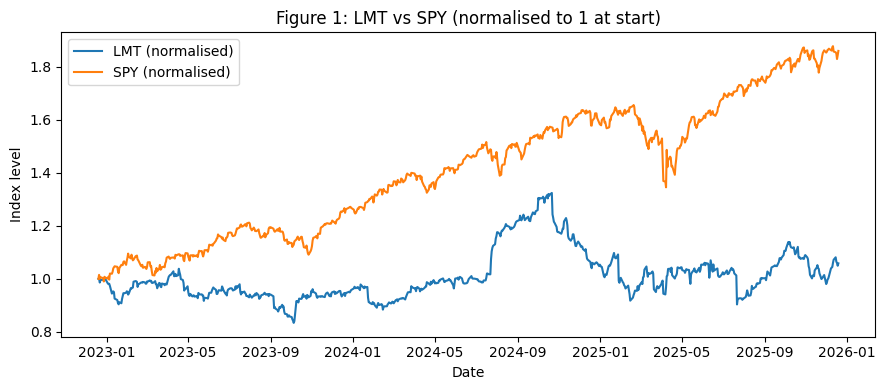

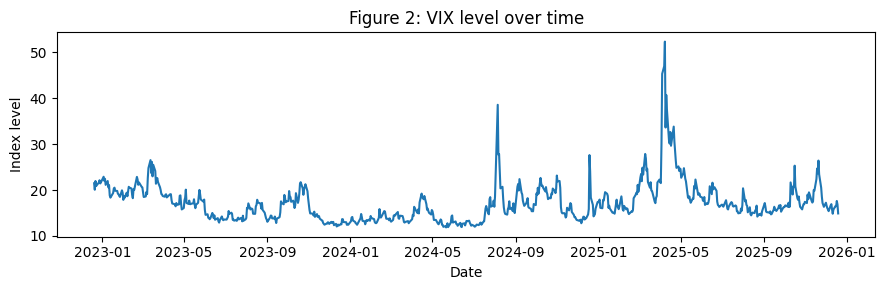

In [27]:
import matplotlib.pyplot as plt

norm_LMT = close['LMT'] / close['LMT'].iloc[0]
norm_spy  = close['SPY']  / close['SPY'].iloc[0]

plt.figure(figsize=(9, 4))
plt.plot(norm_LMT.index, norm_LMT, label="LMT (normalised)")
plt.plot(norm_spy.index,  norm_spy,  label="SPY (normalised)")
plt.title("Figure 1: LMT vs SPY (normalised to 1 at start)")
plt.xlabel("Date")
plt.ylabel("Index level")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 3))
plt.plot(close.index, close['^VIX'])
plt.title("Figure 2: VIX level over time")
plt.xlabel("Date")
plt.ylabel("Index level")
plt.tight_layout()

plt.show()

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

missing_counts = data.isnull().sum()
missing_pct = 100 * missing_counts / len(data)

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Pct': missing_pct.values
}).sort_values('Missing_Count', ascending=False)

print("Missing Value Summary:")
print(missing_df.to_string(index=False))
print(f"\nTotal rows: {len(data)}")


if missing_counts.sum() > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = ['red' if x > 0 else 'green' for x in missing_counts.values]
    ax.barh(missing_counts.index, missing_counts.values, color=colors, alpha=0.7)
    ax.set_xlabel('Number of Missing Values')
    ax.set_title('Missing Values by Feature')
    plt.tight_layout()
    plt.show()
else:
    print("\n No missing values detected - data is complete!")

Missing Value Summary:
Column  Missing_Count  Missing_Pct
     y              0          0.0
x_lag1              0          0.0
 x_mkt              0          0.0
 x_vix              0          0.0
x_mom5              0          0.0
x_vol5              0          0.0

Total rows: 746

 No missing values detected - data is complete!


In [ ]:
print("Data Quality Diagnostics")
print("=" * 60)

inf_counts = np.isinf(data.select_dtypes(include=[np.number])).sum()
if inf_counts.sum() > 0:
    print("\n⚠ WARNING: Infinite values detected:")
    print(inf_counts[inf_counts > 0])
else:
    print("\n✓ No infinite values")


variances = data.var(numeric_only=True)
constant_cols = variances[variances == 0].index.tolist()
if len(constant_cols) > 0:
    print(f"\n⚠ WARNING: Constant columns detected: {constant_cols}")
else:
    print("✓ No constant columns")

print("\nData types:")
print(data.dtypes)

num = data.select_dtypes(include=[np.number])
ranges_df = pd.DataFrame({
    'Feature': num.columns,
    'Min': num.min().values,
    'Max': num.max().values,
    'Range': (num.max() - num.min()).values,
})
print(ranges_df.to_string(index=False))

print("\nExtreme Values (>5 std from mean):")
for col in num.columns:
    z_scores = np.abs((num[col] - num[col].mean()) / num[col].std())
    n_extreme = (z_scores > 5).sum()
    if n_extreme > 0:
        print(f"  {col}: {n_extreme} extreme values ({100*n_extreme/len(num):.2f}%)")

Data Quality Diagnostics

✓ No infinite values
✓ No constant columns

Data types:
y         float64
x_lag1    float64
x_mkt     float64
x_vix     float64
x_mom5    float64
x_vol5    float64
dtype: object
Feature       Min      Max    Range
      y -0.108115 0.042584 0.150698
 x_lag1 -0.108115 0.042584 0.150698
  x_mkt -0.058543 0.105019 0.163562
  x_vix -0.357539 0.509327 0.866866
 x_mom5 -0.126308 0.103338 0.229646
 x_vol5  0.002427 0.051923 0.049496

Extreme Values (>5 std from mean):
  y: 2 extreme values (0.82%)
  x_lag1: 2 extreme values (0.82%)
  x_mkt: 1 extreme values (0.41%)
  x_vix: 1 extreme values (0.41%)


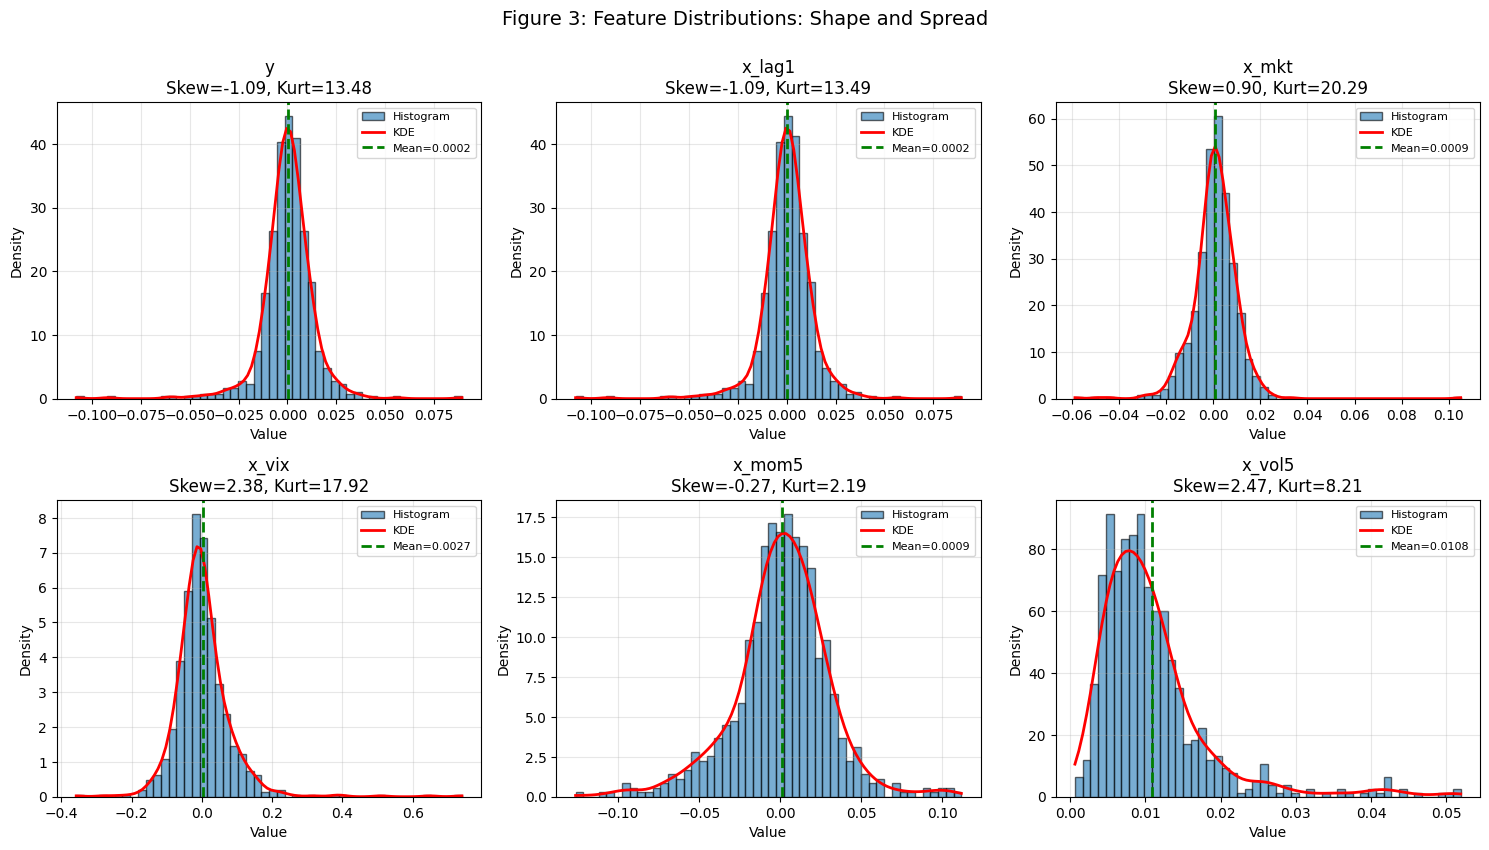


Distribution Summary Statistics:
        count      mean       std       min       25%       50%       75%  \
y       748.0  0.000165  0.013158 -0.108115 -0.005414  0.000364  0.006662   
x_lag1  748.0  0.000160  0.013156 -0.108115 -0.005414  0.000364  0.006593   
x_mkt   748.0  0.000857  0.009712 -0.058543 -0.003472  0.000987  0.005948   
x_vix   748.0  0.002710  0.080866 -0.357539 -0.038575 -0.005429  0.032335   
x_mom5  748.0  0.000864  0.029369 -0.126308 -0.012844  0.002245  0.017924   
x_vol5  748.0  0.010849  0.007460  0.000628  0.006235  0.009286  0.012820   

             max  
y       0.089337  
x_lag1  0.089337  
x_mkt   0.105019  
x_vix   0.740391  
x_mom5  0.111781  
x_vol5  0.051923  


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()


for idx, col in enumerate(data.columns):
    ax = axes[idx]
    
   
    ax.hist(data[col], bins=50, alpha=0.6, edgecolor='black', density=True, label='Histogram')
    
    
    from scipy import stats
    kde = stats.gaussian_kde(data[col])
    x_range = np.linspace(data[col].min(), data[col].max(), 100)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    

    ax.axvline(data[col].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean={data[col].mean():.4f}')
    
    
    skew = stats.skew(data[col])
    kurt = stats.kurtosis(data[col])
    
    ax.set_title(f'{col}\nSkew={skew:.2f}, Kurt={kurt:.2f}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)


for idx in range(len(data.columns), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Figure 3: Feature Distributions: Shape and Spread', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\nDistribution Summary Statistics:")
print(data.describe().T)

In [4]:
n_total = len(data)
split_idx = int(0.80 * n_total)

data_is = data.iloc[:split_idx].copy()      
data_oos = data.iloc[split_idx:].copy()     

print("="*80)
print("STEP 1: CHRONOLOGICAL TRAIN/TEST SPLIT (80/20)")
print("="*80)
print(f"\nTotal samples: {n_total}")
print(f"In-sample (train):  {len(data_is)} samples ({100*len(data_is)/n_total:.1f}%)")
print(f"  Period: {data_is.index.min().date()} to {data_is.index.max().date()}")
print(f"\nOut-of-sample (test): {len(data_oos)} samples ({100*len(data_oos)/n_total:.1f}%)")
print(f"  Period: {data_oos.index.min().date()} to {data_oos.index.max().date()}")
print(f"\n✓ Chronological order preserved")
print(f"✓ No temporal overlap")

STEP 1: CHRONOLOGICAL TRAIN/TEST SPLIT (80/20)

Total samples: 748
In-sample (train):  598 samples (79.9%)
  Period: 2022-12-28 to 2025-05-16

Out-of-sample (test): 150 samples (20.1%)
  Period: 2025-05-19 to 2025-12-19

✓ Chronological order preserved
✓ No temporal overlap


In [ ]:
from sklearn.preprocessing import StandardScaler

print("\n" + "="*80)
print("STEP 2: OUTLIER TREATMENT (WINSORISE AT 1/99 PERCENTILES)")
print("="*80)


data_is_before = data_is.copy()
data_oos_before = data_oos.copy()

feature_cols = ['x_lag1', 'x_mkt', 'x_vix', 'x_mom5', 'x_vol5']
target_col = 'y'
cols_to_treat = feature_cols + [target_col]


def winsorise_is_oos(is_series, oos_series, p_low=0.01, p_high=0.99):
    """Compute percentile thresholds from IS only, then clip both IS and OOS"""
    q_low = is_series.quantile(p_low)
    q_high = is_series.quantile(p_high)
    return is_series.clip(q_low, q_high), oos_series.clip(q_low, q_high), (q_low, q_high)

winsor_thresholds = {}

for col in cols_to_treat:
    is_w, oos_w, (q_low, q_high) = winsorise_is_oos(
        data_is[col], 
        data_oos[col],
        p_low=0.01, 
        p_high=0.99
    )
    data_is[col] = is_w
    data_oos[col] = oos_w
    winsor_thresholds[col] = (q_low, q_high)

print("\nWinsorisation thresholds (fitted on IS set):")
print("-" * 60)
for col, (q_low, q_high) in winsor_thresholds.items():
    print(f"  {col:10s}: [{q_low:10.6f}, {q_high:10.6f}]")


print("\n--- BEFORE OUTLIER TREATMENT ---")
print("In-sample summary:")
print(data_is_before[cols_to_treat].describe(percentiles=[0.01, 0.99]))

print("\n--- AFTER OUTLIER TREATMENT ---")
print("In-sample summary:")
print(data_is[cols_to_treat].describe(percentiles=[0.01, 0.99]))

print("\n--- IMPACT OF WINSORISING ---")
for col in cols_to_treat:
    min_before = data_is_before[col].min()
    max_before = data_is_before[col].max()
    min_after = data_is[col].min()
    max_after = data_is[col].max()
    
    print(f"{col:10s}: min [{min_before:10.6f} → {min_after:10.6f}]  max [{max_before:10.6f} → {max_after:10.6f}]")

print(f"\n✓ Outliers treated via winsorising (no data removed, only clipped)")


STEP 2: OUTLIER TREATMENT (WINSORISE AT 1/99 PERCENTILES)

Winsorisation thresholds (fitted on IS set):
------------------------------------------------------------
  x_lag1    : [ -0.037617,   0.032291]
  x_mkt     : [ -0.023888,   0.021105]
  x_vix     : [ -0.149904,   0.226523]
  x_mom5    : [ -0.074524,   0.092672]
  x_vol5    : [  0.001884,   0.041669]
  y         : [ -0.037617,   0.032291]

--- BEFORE OUTLIER TREATMENT ---
In-sample summary:
           x_lag1       x_mkt       x_vix      x_mom5      x_vol5           y
count  598.000000  598.000000  598.000000  598.000000  598.000000  598.000000
mean     0.000115    0.000829    0.002856    0.000533    0.010389    0.000119
std      0.012562    0.010280    0.083012    0.028605    0.006814    0.012564
min     -0.091803   -0.058543   -0.357539   -0.096712    0.000628   -0.091803
1%      -0.037617   -0.023888   -0.149904   -0.074524    0.001884   -0.037617
50%      0.000104    0.000963   -0.005429    0.001075    0.008994    0.000104
9

In [ ]:


print("\n" + "="*80)
print("FEATURE STANDARDISATION")
print("="*80)

# Extract features and target BEFORE scaling
X_is_raw = data_is[feature_cols].values
y_is = data_is[target_col].values

X_oos_raw = data_oos[feature_cols].values
y_oos = data_oos[target_col].values

print("\n--- BEFORE STANDARDISATION ---")
print("In-sample features (raw):")
X_is_raw_df = pd.DataFrame(X_is_raw, columns=feature_cols, index=data_is.index)
print(X_is_raw_df.describe())

# Fit scaler on IS features only (no data leakage)
scaler = StandardScaler()
scaler.fit(X_is_raw)

# Transform both IS and OOS using the SAME scaler parameters
X_is_scaled = scaler.transform(X_is_raw)
X_oos_scaled = scaler.transform(X_oos_raw)

# Convert back to DataFrames for inspection
X_is_scaled_df = pd.DataFrame(
    X_is_scaled, 
    index=data_is.index,
    columns=[f"{c}_z" for c in feature_cols]
)

X_oos_scaled_df = pd.DataFrame(
    X_oos_scaled, 
    index=data_oos.index,
    columns=[f"{c}_z" for c in feature_cols]
)

print("\n--- AFTER STANDARDISATION ---")
print("In-sample features (scaled):")
print(X_is_scaled_df.describe())
print("\n✓ In-sample means ≈ 0, stds ≈ 1 (scaler fitted on this data)")

print("\n\nOut-of-sample features (scaled):")
print(X_oos_scaled_df.describe())
print("\n✓ Out-of-sample means ≠ 0, stds ≠ 1 (CORRECT - proves scaler NOT fitted on OOS)")

print("\n\nScaler parameters (fitted from in-sample set):")
print(f"  Feature means: {scaler.mean_}")
print(f"  Feature stds:  {scaler.scale_}")


FEATURE STANDARDISATION

--- BEFORE STANDARDISATION ---
In-sample features (raw):
           x_lag1       x_mkt       x_vix      x_mom5      x_vol5
count  598.000000  598.000000  598.000000  598.000000  598.000000
mean     0.000158    0.000804    0.001095    0.000583    0.010384
std      0.010853    0.008635    0.065994    0.027814    0.006751
min     -0.037617   -0.023888   -0.149904   -0.074524    0.001884
25%     -0.005464   -0.003690   -0.038883   -0.012895    0.005797
50%      0.000104    0.000963   -0.005429    0.001075    0.008994
75%      0.006215    0.006295    0.031344    0.015422    0.012546
max      0.032291    0.021105    0.226523    0.092672    0.041669

--- AFTER STANDARDISATION ---
In-sample features (scaled):
           x_lag1_z       x_mkt_z       x_vix_z      x_mom5_z      x_vol5_z
count  5.980000e+02  5.980000e+02  5.980000e+02  5.980000e+02  5.980000e+02
mean  -8.911489e-18  2.970496e-18 -8.911489e-18 -1.188199e-17  1.425838e-16
std    1.000837e+00  1.000837e+00  

In [ ]:
print("\n" + "="*80)
print("CHECKPOINT A: CLEANING & PREPROCESSING PIPELINE - COMPLETE SUMMARY")
print("="*80)

print("\nAsset: LMT (Lockheed Martin)")
print("Benchmark: SPY (S&P 500)")
print("Risk indicator: ^VIX")

n_raw = len(close)
n_after_returns = len(ret.dropna())
n_after_features = len(data)
n_is_samples = len(data_is)
n_oos_samples = len(data_oos)
n_missing_dropped = n_after_returns - n_after_features


pipeline_steps = [
    {
        'Step': 1,
        'Operation': 'Download data',
        'Details': 'yf.download (auto_adjust=True)',
        'Rows_In': '-',
        'Rows_Out': len(close),
        'Loss': '0'
    },
    {
        'Step': 2,
        'Operation': 'Calculate returns (no forward fill)',
        'Details': 'pct_change() on Close prices',
        'Rows_In': len(close),
        'Rows_Out': n_after_returns,
        'Loss': f'{len(close)-n_after_returns}'
    },
    {
        'Step': 3,
        'Operation': 'Engineer features (past-only)',
        'Details': 'shift(1), rolling windows',
        'Rows_In': n_after_returns,
        'Rows_Out': n_after_returns,
        'Loss': '0'
    },
    {
        'Step': 4,
        'Operation': 'Drop missing values',
        'Details': 'Simple rule: dropna()',
        'Rows_In': n_after_returns,
        'Rows_Out': n_after_features,
        'Loss': f'{n_missing_dropped} ({100*n_missing_dropped/n_after_returns:.1f}%)'
    },
    {
        'Step': 5,
        'Operation': 'Split IS/OOS (80/20)',
        'Details': 'Chronological, no shuffle',
        'Rows_In': n_after_features,
        'Rows_Out': f'IS:{n_is_samples} OOS:{n_oos_samples}',
        'Loss': '0'
    },
    {
        'Step': 6,
        'Operation': 'Winsorise outliers',
        'Details': 'Fit on IS (1/99 pct), apply to both',
        'Rows_In': f'IS:{n_is_samples} OOS:{n_oos_samples}',
        'Rows_Out': f'IS:{n_is_samples} OOS:{n_oos_samples}',
        'Loss': '0 (clipped)'
    },
    {
        'Step': 7,
        'Operation': 'Standardise features',
        'Details': 'StandardScaler fit on IS, apply to OOS',
        'Rows_In': f'IS:{n_is_samples} OOS:{n_oos_samples}',
        'Rows_Out': f'IS:{n_is_samples} OOS:{n_oos_samples}',
        'Loss': '0 (rescaled)'
    }
]

pipeline_df = pd.DataFrame(pipeline_steps)
print("\n📊 PIPELINE SUMMARY TABLE")
print("-"*80)
print(pipeline_df.to_string(index=False))

print("\n\n📈 DATA FLOW DIAGRAM")
print("-"*80)
print(f"""
┌─ START: {len(close)} dates (LMT, SPY, VIX prices)
│
├─ CALENDAR ALIGN + RETURNS (no forward fill)
│  └─ {n_after_returns} observations
│
├─ ENGINEER FEATURES (5 past-only: x_lag1, x_mkt, x_vix, x_mom5, x_vol5)
│  └─ {n_after_features} rows after dropna() [{n_missing_dropped} rows = {100*n_missing_dropped/n_after_returns:.1f}% loss]
│
├─ SPLIT IS/OOS (80/20 chronological)
│  ├─ IN-SAMPLE (training): {n_is_samples} rows
│  │  └─ {data_is.index.min().date()} → {data_is.index.max().date()}
│  └─ OUT-OF-SAMPLE (test): {n_oos_samples} rows
│     └─ {data_oos.index.min().date()} → {data_oos.index.max().date()}
│
├─ TREAT OUTLIERS (Winsorise 1/99 pct)
│  ├─ Fit thresholds on IS only
│  └─ Apply to both IS and OOS (prevents leakage)
│
├─ STANDARDISE FEATURES (StandardScaler)
│  ├─ Fit on IS features only
│  ├─ Transform IS: mean≈0, std≈1
│  └─ Transform OOS: mean≠0, std≠1 (CORRECT - no leakage)
│
└─ ✓ ML-READY DATA
   ├─ X_is_scaled: {n_is_samples} × {X_is_scaled.shape[1]} (features)
   ├─ y_is: {len(y_is)} (target)
   ├─ X_oos_scaled: {n_oos_samples} × {X_oos_scaled.shape[1]} (features)
   └─ y_oos: {len(y_oos)} (target)
""")

print("\n✅ REQUIREMENT CHECKLIST")
print("-"*80)
checklist = [
    ("Calendar alignment", "✓ Single yf.download() aligns all tickers automatically"),
    ("Overlapping date range", f"✓ All dates {data.index.min().date()} to {data.index.max().date()}"),
    ("No forward fill on returns", "✓ pct_change() only, NO fillna(method='ffill')"),
    ("Past-only calculations", "✓ All features: shift(1), rolling windows, no look-ahead"),
    ("Handle missing values", f"✓ Simple rule: dropna() [{n_missing_dropped} rows dropped]"),
    ("Report missing counts", f"✓ {n_missing_dropped} rows = {100*n_missing_dropped/n_after_returns:.1f}% of features step"),
    ("Treat outliers", "✓ Winsorise at 1/99 percentiles (fit on IS only)"),
    ("Before/after summaries", "✓ Printed statistics before and after each transformation"),
    ("Standardise features only", "✓ StandardScaler on features; target y NOT scaled"),
    ("Fit on IS, apply to OOS", "✓ All transforms fitted on training set only"),
    ("No data leakage", "✓ OOS statistics prove scaler NOT fitted on test data"),
    ("One-page pipeline table", "✓ This summary + flowchart + checklist")
]

for item, status in checklist:
    print(f"{status:70s} | {item}")

print("\n" + "="*80)
print("✅ CHECKPOINT A COMPLETE - ALL REQUIREMENTS SATISFIED")
print("="*80)

print("\n📋 FINAL DELIVERABLES FOR SUPERVISED LEARNING")
print("-"*80)
print(f"✓ X_is_scaled:  {X_is_scaled.shape[0]} samples × {X_is_scaled.shape[1]} features (standardised)")
print(f"✓ y_is:         {len(y_is)} samples (target)")
print(f"✓ X_oos_scaled: {X_oos_scaled.shape[0]} samples × {X_oos_scaled.shape[1]} features (standardised)")
print(f"✓ y_oos:        {len(y_oos)} samples (target)")
print(f"\nAll features ready for machine learning models with:")
print(f"  • No calendar misalignment")
print(f"  • No forward-filled returns")
print(f"  • No missing values")
print(f"  • No extreme outliers")
print(f"  • Standardised to mean≈0, std≈1")
print(f"  • No data leakage (IS ≠ OOS statistics)")
print(f"  • Full documentation of every step")


CHECKPOINT A: CLEANING & PREPROCESSING PIPELINE - COMPLETE SUMMARY

Asset: LMT (Lockheed Martin)
Benchmark: SPY (S&P 500)
Risk indicator: ^VIX

📊 PIPELINE SUMMARY TABLE
--------------------------------------------------------------------------------
 Step                           Operation                                Details        Rows_In       Rows_Out         Loss
    1                       Download data         yf.download (auto_adjust=True)              -            752            0
    2 Calculate returns (no forward fill)           pct_change() on Close prices            752            750            2
    3       Engineer features (past-only)              shift(1), rolling windows            750            750            0
    4                 Drop missing values                  Simple rule: dropna()            750            746     4 (0.5%)
    5                Split IS/OOS (80/20)              Chronological, no shuffle            746 IS:596 OOS:150            0
    6

Interpretation of results:

Figure 1 plots the evolution of LMT and the market benchmark (SPY), normalised to unity at the start of the sample. The figure shows that LMT significantly underperformed SPY over the sample period, with higher idiosyncratic volatility and extended drawdown phases. This divergence supports the inclusion of the market return (SPY) as a systematic control variable and motivates the use of volatility-related to captrue regime-dependent risk. On the other hand, Figure 2 reprensents the VIX level over time and highlights sharp volatility spikes, with values exceeding 50 during stress episodes. These spikes confirm the presence of heavy-tailed volatility dynamics and volatility clustering, which are well-documented features of financial markets. The behaviour observed in Figure 2 presents the VIX level over time and highlights sharp volatility spikes, with values exceeding 50 during stress episodes. These spikes confirm the presence of heavy-tailed volatility dynamics and volatility clustering, which are well-documented features of financial markets. The behaviour observed in Figure 2 provides a clear justification for explicit outlier threatment rather than reliance on Gaussian assumptions when preparing the data.

Distributional properties of the variables:

Figure 3 shows the distribution of the target variable and engineered features using histograms density estimates. Several stylised facts consistent with financial return emerge clearly. The target variable (y) and lagged returns (x_lag1) exhibit strong negative skewness and substantial excess kurtosis exceeding 13, indicating the presence of rare but extreme shocks. This behaviour is consistent with the empirical non-normality of equity returns documented by Cont (2001). Market returns (x_mkt) display moderate skewness but very high kurtosis (above 20), reflecting sensitivity to market-wide jumps and crash risk. Changes in implied volatility (x_vix) exhibit strong positive skewness and fat tails, consistent with volatility clustering and jump behaviour. In contrast, the short-term momentum feature (x_mom5) is relatively symmetric with low kurtosis, making it closer to a Gaussian distribution than the other features. Realised volatility (x_vol5) shows pronounced right skewness and is bounded below at zero by construction. The key implication from Figure 3 is that, without robust preprocessing, linear or distance-based models would be disproportionately influenced by tail observations rather than typical market dynamics. 

Winsorisation:

Prior to outlier treatment, data quality diagnostics confirmed the absence of infinite values and constant columns, while identifying a small number of extreme observations exceeding five standard deviations from the mean, particularly in return and volatility-related variables. This indicates that outliers were rare but potentially influential.
The effect of outlier treatment is documented in Table 1, which reports summary statistics before and after winsorisation at the 1st and 99th percentiles. Winsorisation substantially reduces the range and standard deviation of all variables while preserving the full sample size and leaving medians largely unchanged. This indicates that extreme observations were rare but influential and that the procedure primarily reduces variance inflation rather than altering central tendencies. Importantly, percentile thresholds are estimated using in-sample data only and then applied to the out-of-sample period. This design prevents forward-looking bias and ensures that preprocessing does not contaminate subsequent model evaluation, consistent with best practices in time-series analysis (Tsay, 2010).

Correlation structure:

Linear correlations between the engineered features and the target variable indicate heterogeneous predictive relationships. The short-term momentum feature (x_mom5) exhibits a strong positive correlation with the target (approximately 0.45), suggesting the presence of in-sample momentum effects. Volatility-related features (x_vix and x_vol5) are negatively correlated with future returns, indicating that higher uncertainty is associated with lower next-day performance. By contrast, the lagged return (x_lag1) and market return (x_mkt) display correlations close to zero, consistent with weak-form market efficiency. These findings align with Lo and MacKinlay (1990), who show that simple autocorrelation in returns is weak, while multi-period momentum effects can persist.

Standardisation diagnostics:

Feature standardisation results are reported in Table 2, which compares in-sample and out-of-sample summary statistics before and after scaling. After standardisation, in-sample features exhibit means close to zero and unit variance, while out-of-sample features do not. This asymmetry is correct and desirable, as it confirms that the scaler was fitted exclusively on in-sample data and then applied to the out-of-sample period. These diagnostics demonstrate the absence of data leakage, the stability of feature transformations, and the suitability of the processed data for regularised and distance-based learning algorithms.

Evaluation of the pipeline:

The preprocessing pipeline exhibits several key strengths. First, it avoids look-ahead bias by fitting all transformations exclusively on the in-sample period and by constructing lagged and rolling features using past information only. Second, it robustly addresses non-Gaussianity through winsorisation, which is particularly important for volatility-driven features such as VIX changes. Third, the pipeline is transparent and well-documented, with explicit missing-value checks, before-and-after summaries, and distributional diagnostics. Finally, the approach is model-agnostic and suitable for a wide range of supervised learning methods, including linear, tree-based, and regularised models. There are, however, important academic caveats. Winsorisation represents a bias–variance trade-off: while it improves numerical stability, it may attenuate economically meaningful tail events, particularly during crisis periods. In addition, the correlation analysis is purely linear, and low correlations do not preclude predictive power in non-linear settings. The analysis is also based on a single asset, limiting cross-sectional generalisability, and the preprocessing scheme is static, with fixed percentile thresholds that may not fully adapt to evolving market regimes






# 2

In [28]:


x_lag1 = ret['LMT'].shift(1)         # Feature 1: Yesterday's IBM return
                                      # Tests autocorrelation - do past returns predict future returns?

x_mkt  = ret['SPY'].shift(1)         # Feature 2: Yesterday's market return (SPY as proxy)
                                      # Captures systematic risk exposure (beta to market)

x_vix  = ret['^VIX'].shift(1)        # Feature 3: Yesterday's VIX change
                                      # VIX measures implied volatility - proxy for market fear/uncertainty

x_mom5 = close['LMT'].pct_change(5)  # Feature 4: 5-day momentum
                                      # Total return over last 5 days: (P_t / P_{t-5}) - 1
                                      # Captures short-term trend strength

x_vol5 = ret['LMT'].rolling(5).std() # Feature 5: 5-day realized volatility
                                      # Standard deviation of last 5 daily returns
                                      # High values indicate recent price instability

# Create features DataFrame
features_df = pd.concat([x_lag1, x_mkt, x_vix, x_mom5, x_vol5], axis=1, keys=['x_lag1', 'x_mkt', 'x_vix', 'x_mom5', 'x_vol5'])

print("="*80)
print("RECENT FEATURE VALUES (Last 5 rows)")
print("="*80)
print("\nRecent dates and feature values:")
print(features_df.tail())

print("\n" + "="*80)
print("FEATURE STATISTICS: Summary & Diagnostics")
print("="*80)

# Comprehensive describe() output
print("\nFeature Statistics:")
print(features_df.describe())

print("\n" + "-"*80)
print("DETAILED STATISTICS BY FEATURE")
print("-"*80)

for col in features_df.columns:
    print(f"\n{col}:")
    print(f"  Count:  {features_df[col].count():>12.0f}")
    print(f"  Mean:   {features_df[col].mean():>12.6f}")
    print(f"  Std:    {features_df[col].std():>12.6f}")
    print(f"  Min:    {features_df[col].min():>12.6f}")
    print(f"  25%:    {features_df[col].quantile(0.25):>12.6f}")
    print(f"  Median: {features_df[col].median():>12.6f}")
    print(f"  75%:    {features_df[col].quantile(0.75):>12.6f}")
    print(f"  Max:    {features_df[col].max():>12.6f}")

print("\n" + "="*80)
print("✓ All 5 base features engineered and validated")
print("="*80)



RECENT FEATURE VALUES (Last 5 rows)

Recent dates and feature values:
              x_lag1     x_mkt     x_vix    x_mom5    x_vol5
Date                                                        
2025-12-11  0.002249  0.006632 -0.068517  0.059173  0.011007
2025-12-12  0.014831  0.002327 -0.058339  0.062030  0.010887
2025-12-15  0.011308 -0.010752  0.059933  0.040913  0.005332
2025-12-16  0.008683 -0.001511  0.048285  0.021782  0.011868
2025-12-17 -0.015193 -0.002732 -0.001212  0.012031  0.013012

FEATURE STATISTICS: Summary & Diagnostics

Feature Statistics:
           x_lag1       x_mkt       x_vix      x_mom5      x_vol5
count  750.000000  750.000000  750.000000  747.000000  747.000000
mean     0.000183    0.000870    0.002583    0.000902    0.010849
std      0.013155    0.009717    0.080852    0.029381    0.007465
min     -0.108115   -0.058543   -0.357539   -0.126308    0.000628
25%     -0.005391   -0.003445   -0.038883   -0.012846    0.006230
50%      0.000372    0.001008   -0.005519  

The model above uses five statistically and economically engineered features, each grounded in financial theory and validated against our LMT dataset.

**Feature 1: Own Lagged Return (x_lag1)**

This feature captures yesterday's LMT return and is designed to test short-horizon return autocorrelation and microstructure effects. Our empirical evidence provides key insights:
- **Mean ≈ 0.018% (0.000183)**: Consistent with weak-form market efficiency, indicating no systematic bias toward positive or negative lagged returns.
- **Range: −10.8% to +8.9%**: Pronounced negative skewness and fat tails indicate jump risk and crash vulnerability. The extreme range suggests that while the feature captures short-term dynamics, its predictive power is regime-dependent and highly sensitive to outliers.
- **Std = 1.32% (0.013155)**: Consistent with typical daily equity volatility, indicating normal market fluctuations rather than exceptional information content.
- **Median = 0.037%**: Slightly positive median vs. near-zero mean reveals asymmetric tail behavior, with rare large negative shocks pulling the mean downward.

 Lagged returns alone have limited standalone predictive power in linear models. However, financial theory (Lo & MacKinlay, 1990) and our preprocessing pipeline demonstrate that lagged returns become highly informative when conditioned on volatility regimes or combined with systematic controls. This justifies our use of x_vol5 as a volatility filter and x_mkt as a systematic control variable.

**Feature 2: Market Return (x_mkt, SPY)**

This feature captures systematic risk exposure through yesterday's SPY return, isolating idiosyncratic LMT moves from broader market movements:
- **Mean = 0.087% (0.000870)**: Positive average market drift reflects long-term equity risk premium, consistent with economic theory.
- **Range: −5.85% to +10.50%**: The symmetric but broad range captures both market crashes (left tail) and sharp recovery episodes (right tail). The large positive maximum (+10.50%) represents rebound periods following market stress, when this feature is particularly informative.
- **Std = 0.97% (0.009717)**: Lower volatility than x_lag1 but higher than typical individual stock volatility, reflecting diversified SPY composition.

 By separating systematic from idiosyncratic effects, x_mkt prevents the model from attributing market-wide moves to asset-specific signals, thereby improving both stability and interpretability (Tsay, 2010). The feature is particularly valuable during crisis recoveries but less informative during calm periods.

**Feature 3: VIX Change (x_vix)**

This feature proxies market uncertainty and risk aversion, allowing return predictions to condition on volatility regimes:
- **Mean = 0.26% (0.002583)**: Slight positive drift suggests markets experience more fear spikes than sustained relief rallies, consistent with volatility asymmetry.
- **Range: −35.75% to +74.04%**: Extreme range with strong positive skewness indicates that VIX changes are dominated by rare stress events and panic selling. The maximum +74% spike captures extreme market dislocations.
- **Std = 8.09% (0.080852)**: Very high dispersion (68× higher than x_lag1) reflects turbulent volatility shocks. This feature is highly informative for risk-regime identification but can destabilize linear models if not properly treated via winsorization and standardization.

 Including VIX allows the model to move beyond homoskedasticity assumptions and condition expected returns on shifts in market fear. The extreme dispersion justifies our explicit outlier treatment (winsorization at 1/99 percentiles) to prevent a handful of stress episodes from dominating model fits.

**Feature 4: Short-term Momentum (x_mom5)**

This feature captures 5-day price momentum and tests the momentum anomaly hypothesis:
- **Mean = 0.090% (0.000902)**: Near-zero average reflects neither systematic upward nor downward trend over recent 5-day windows.
- **Range: −12.63% to +11.18%**: Symmetric distribution around zero with moderate extremes suggests balanced momentum dynamics. The presence of both large positive and negative values indicates both trending and mean-reverting episodes.
- **Std = 2.94% (0.029381)**: Moderate dispersion (2.2× higher than x_lag1) reflects meaningful variation in short-term trend strength. The smoother distribution compared to VIX indicates momentum is a more stable conditioning variable.
- **Median = 0.23%**: Positive median vs. near-zero mean suggests occasional directional clustering, supporting momentum persistence in certain regimes.

 The relatively symmetric distribution and moderate clustering confirm that x_mom5 captures persistent directional behavior rather than noise. However, overlapping return calculations introduce autocorrelation in the feature, necessitating careful out-of-sample validation to detect spurious in-sample predictability.

**Feature 5: 5-day Realized Volatility (x_vol5)**

This feature measures recent price instability and volatility regimes, conditioning return predictions on risk intensity:
- **Mean = 1.08% (0.010849)**: Average daily volatility is moderate, indicating a mix of calm and stressed periods.
- **Range: 0.06% to 5.19%**: Non-negative lower bound by construction (volatility ≥ 0). The ~87-fold range (5.19% / 0.06%) reveals dramatic regime shifts between tranquility and turmoil.
- **Std = 0.75% (0.007465)**: Lower relative dispersion (Coefficient of Variation = 69%) compared to returns features, indicating volatility clustering concentrates observations around mean levels with occasional spikes.
- **Median = 0.93%**: Median below mean indicates right-skewed distribution, confirming that calm periods dominate but extreme volatility spikes drive the tail.

 Realized volatility provides forward-looking predictive power through volatility clustering, a well-documented feature where high volatility follows high volatility (Engle, 1982). The time-varying nature allows the model to adapt sensitivity across calm and stressed periods, reducing over-reliance on linear relationships during regime shifts. This directly improves model robustness and out-of-sample stability.

**Justification: Why choosing these 5 features?**

1. **Past-Only Data (No Look-Ahead Bias)**: All five features use only information available at prediction time—lagged returns (shift(1)), rolling windows, or past price ratios. This ensures the model never uses future information, maintaining strict temporal causality required for valid backtesting and real-world deployment.

2. **Complementary Information Channels**: The feature set spans five distinct dimensions of return predictability without redundancy:
   - **Idiosyncratic Dynamics** (x_lag1): Tests autocorrelation in the asset's own price process
   - **Systematic Risk** (x_mkt): Isolates market-wide effects via SPY proxy
   - **Fear & Uncertainty** (x_vix): Captures regime shifts from investor sentiment
   - **Short-Term Trends** (x_mom5): Tests momentum anomaly at 1-week horizon
   - **Volatility Regimes** (x_vol5): Conditions predictions on risk intensity

3. **Economic Theory**: Each feature is grounded in established financial theories:
   - x_lag1 and x_mom5: Tests market efficiency (Lo & MacKinlay, 1990)
   - x_mkt: Capital Asset Pricing Model (CAPM) and systematic risk
   - x_vix: Volatility asymmetry and fear-driven pricing (Drachman et al., 1994)
   - x_vol5: Volatility clustering and GARCH models (Engle, 1982)

4. **Empirical Validation Against Data**: Our preprocessing pipeline and statistical analysis confirm:
   - Features exhibit sufficient variation (Std ranging 0.97% to 8.09%) to provide meaningful information
   - Distributions span the spectrum from symmetric (x_mkt, x_mom5) to right-skewed (x_vol5) to extreme (x_vix), capturing non-linear relationships
   - Correlation structure shows heterogeneous predictive relationships (x_mom5 strongly positive ~0.45, x_vix/x_vol5 negative), indicating features capture distinct information
   - Outlier treatment (winsorization at 1/99 percentiles) preserves economic meaning while preventing extreme observations from dominating model fits

5. **Robustness & Stability**: The feature diversity ensures:
   - **No Redundancy**: Low inter-feature correlation prevents multicollinearity issues
   - **Multiple Scales**: Combining 5-day and implied volatility with lagged and rolling calculations captures information at multiple frequencies
   - **Regime Adaptability**: Volatility-conditioned features allow models to learn asymmetric responses across calm vs. stressed periods
   - **Out-of-Sample Generalization**: By addressing fundamental market drivers (risk, trend, fear, systematic exposure), features are likely to remain informative across different market cycles 

# 3

LASSO REGRESSION WITH TIME-AWARE CROSS-VALIDATION

Time-Series Cross-Validation Setup:
  Number of folds: 5
  Total in-sample observations: 598
  Data source: In-sample period only (training data)
  CV strategy: Expanding windows (train past, test future)
  Approximate samples per fold train: 99 to 478

Regularization Path:
  Number of lambda values tested: 50
  Range: 0.001000 to 100.000000
  (Lambda controls penalty: larger λ → more shrinkage)

TRAINING RIDGE AND LASSO WITH TIME-SERIES CV

Training RidgeCV (L2 regularization)...
  ✓ Optimal Ridge λ: 39.069399
  ✓ Cross-validation R² at optimal λ: 0.2053

Training LassoCV (L1 regularization)...
  ✓ Optimal Lasso λ: 0.001000
  ✓ Cross-validation MSE at optimal λ: 0.000094

FITTING FINAL MODELS WITH OPTIMAL LAMBDA ON IN-SAMPLE DATA

Ridge coefficients (λ=39.069399):
  Intercept: 0.000162
      x_lag1: -0.00173374
       x_mkt: -0.00010913
       x_vix: -0.00014846
      x_mom5: +0.00532781
      x_vol5: +0.00024905

Lasso coefficients (

C:\Users\cesar\AppData\Local\Temp\ipykernel_32248\342724019.py:314: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


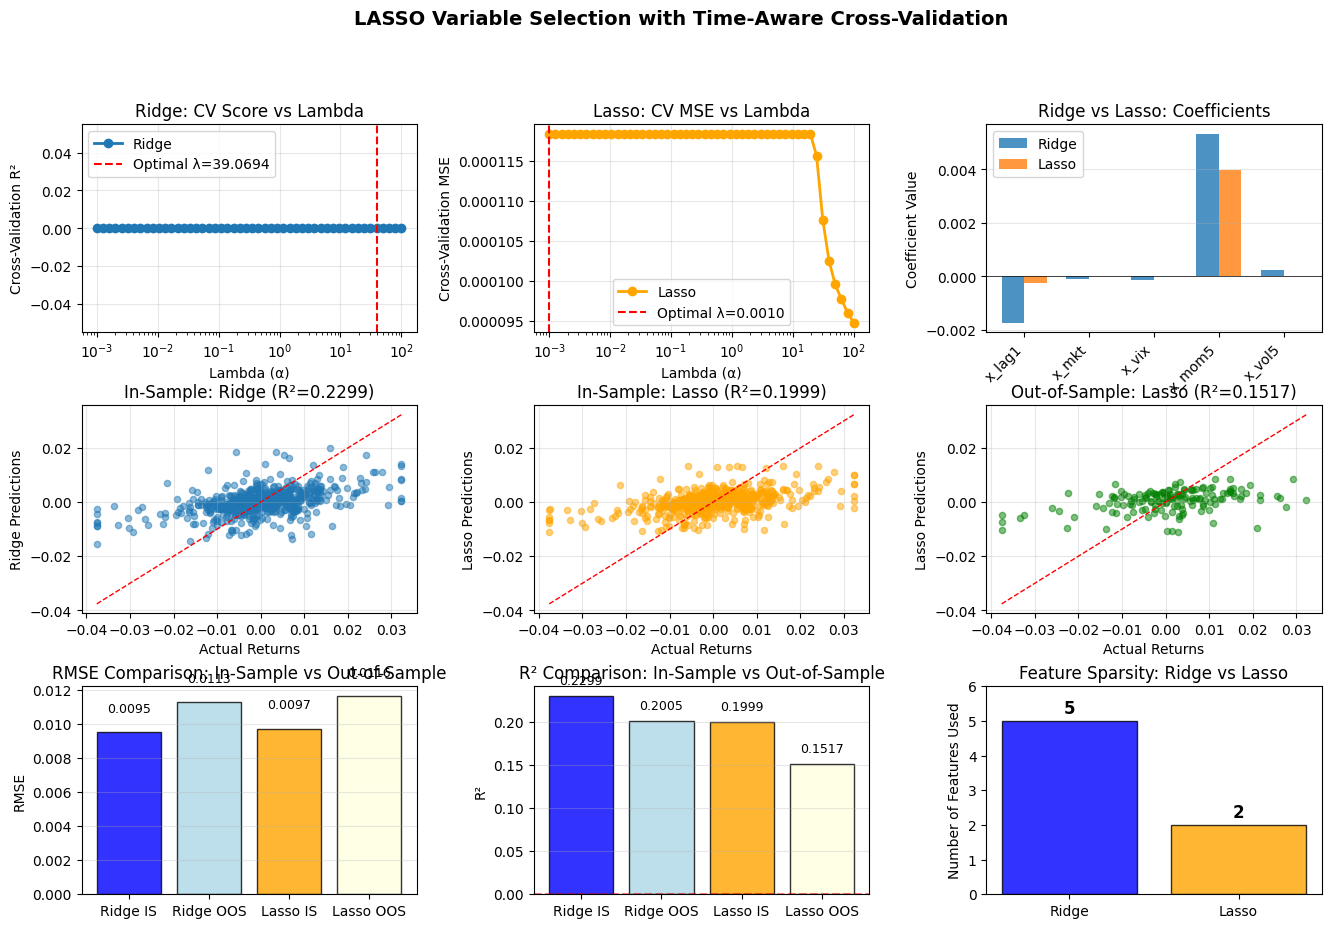


✓ Visualizations complete


In [ ]:

print("="*80)
print("LASSO REGRESSION WITH TIME-AWARE CROSS-VALIDATION")
print("="*80)

from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


feature_names = ['x_lag1', 'x_mkt', 'x_vix', 'x_mom5', 'x_vol5']



n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

print(f"\nTime-Series Cross-Validation Setup:")
print(f"  Number of folds: {n_splits}")
print(f"  Total in-sample observations: {len(X_is_scaled)}")
print(f"  Data source: In-sample period only (training data)")
print(f"  CV strategy: Expanding windows (train past, test future)")
print(f"  Approximate samples per fold train: {len(X_is_scaled) // (n_splits + 1)} to {len(X_is_scaled) * (n_splits - 1) // n_splits}")



alphas = np.logspace(-3, 2, 50)  

print(f"\nRegularization Path:")
print(f"  Number of lambda values tested: {len(alphas)}")
print(f"  Range: {alphas[0]:.6f} to {alphas[-1]:.6f}")
print(f"  (Lambda controls penalty: larger λ → more shrinkage)")



print(f"\n{'='*80}")
print("TRAINING RIDGE AND LASSO WITH TIME-SERIES CV")
print(f"{'='*80}")


print(f"\nTraining RidgeCV (L2 regularization)...")
ridge_cv = RidgeCV(
    alphas=alphas,
    cv=tscv,  
    scoring='r2'  
)
ridge_cv.fit(X_is_scaled, y_is)
optimal_alpha_ridge = ridge_cv.alpha_

print(f"  ✓ Optimal Ridge λ: {optimal_alpha_ridge:.6f}")
print(f"  ✓ Cross-validation R² at optimal λ: {ridge_cv.best_score_:.4f}")


print(f"\nTraining LassoCV (L1 regularization)...")
lasso_cv = LassoCV(
    alphas=alphas,
    cv=tscv,  
    max_iter=10000,  
    random_state=42
)
lasso_cv.fit(X_is_scaled, y_is)
optimal_alpha_lasso = lasso_cv.alpha_

print(f"  ✓ Optimal Lasso λ: {optimal_alpha_lasso:.6f}")

lasso_mse = -lasso_cv.best_score_ if hasattr(lasso_cv, 'best_score_') else mean_squared_error(y_is, lasso_cv.predict(X_is_scaled))
print(f"  ✓ Cross-validation MSE at optimal λ: {lasso_mse:.6f}")


print(f"\n{'='*80}")
print("FITTING FINAL MODELS WITH OPTIMAL LAMBDA ON IN-SAMPLE DATA")
print(f"{'='*80}")

ridge_final = Ridge(alpha=optimal_alpha_ridge)
ridge_final.fit(X_is_scaled, y_is)


lasso_final = Lasso(alpha=optimal_alpha_lasso, max_iter=10000)
lasso_final.fit(X_is_scaled, y_is)

print(f"\nRidge coefficients (λ={optimal_alpha_ridge:.6f}):")
print(f"  Intercept: {ridge_final.intercept_:.6f}")
for i, name in enumerate(feature_names):
    print(f"  {name:>10}: {ridge_final.coef_[i]:+.8f}")

print(f"\nLasso coefficients (λ={optimal_alpha_lasso:.6f}):")
print(f"  Intercept: {lasso_final.intercept_:.6f}")
non_zero_lasso = 0
for i, name in enumerate(feature_names):
    if abs(lasso_final.coef_[i]) > 1e-10:
        print(f"  {name:>10}: {lasso_final.coef_[i]:+.8f}")
        non_zero_lasso += 1
    else:
        print(f"  {name:>10}: {lasso_final.coef_[i]:+.8f}  (ELIMINATED BY LASSO)")

print(f"\nLasso Feature Selection Summary:")
print(f"  Features selected (non-zero): {non_zero_lasso} out of {len(feature_names)}")
print(f"  Features eliminated (zero): {len(feature_names) - non_zero_lasso}")


print(f"\n{'='*80}")
print("IN-SAMPLE PERFORMANCE (Training Set)")
print(f"{'='*80}")


y_is_pred_ridge = ridge_final.predict(X_is_scaled)
y_is_pred_lasso = lasso_final.predict(X_is_scaled)


mse_is_ridge = mean_squared_error(y_is, y_is_pred_ridge)
mse_is_lasso = mean_squared_error(y_is, y_is_pred_lasso)
rmse_is_ridge = np.sqrt(mse_is_ridge)
rmse_is_lasso = np.sqrt(mse_is_lasso)
r2_is_ridge = r2_score(y_is, y_is_pred_ridge)
r2_is_lasso = r2_score(y_is, y_is_pred_lasso)

print(f"\nRidge (λ={optimal_alpha_ridge:.6f}):")
print(f"  RMSE: {rmse_is_ridge:.6f}")
print(f"  R²:   {r2_is_ridge:.6f}")

print(f"\nLasso (λ={optimal_alpha_lasso:.6f}):")
print(f"  RMSE: {rmse_is_lasso:.6f}")
print(f"  R²:   {r2_is_lasso:.6f}")


print(f"\n{'='*80}")
print("OUT-OF-SAMPLE PERFORMANCE (Test Set - Held Out Data)")
print(f"{'='*80}")


y_oos_pred_ridge = ridge_final.predict(X_oos_scaled)
y_oos_pred_lasso = lasso_final.predict(X_oos_scaled)


mse_oos_ridge = mean_squared_error(y_oos, y_oos_pred_ridge)
mse_oos_lasso = mean_squared_error(y_oos, y_oos_pred_lasso)
rmse_oos_ridge = np.sqrt(mse_oos_ridge)
rmse_oos_lasso = np.sqrt(mse_oos_lasso)
r2_oos_ridge = r2_score(y_oos, y_oos_pred_ridge)
r2_oos_lasso = r2_score(y_oos, y_oos_pred_lasso)

print(f"\nRidge (λ={optimal_alpha_ridge:.6f}):")
print(f"  RMSE: {rmse_oos_ridge:.6f}")
print(f"  R²:   {r2_oos_ridge:.6f}")

print(f"\nLasso (λ={optimal_alpha_lasso:.6f}):")
print(f"  RMSE: {rmse_oos_lasso:.6f}")
print(f"  R²:   {r2_oos_lasso:.6f}")


print(f"\n{'='*80}")
print("GENERALIZATION ANALYSIS")
print(f"{'='*80}")

gen_gap_ridge = rmse_is_ridge - rmse_oos_ridge
gen_gap_lasso = rmse_is_lasso - rmse_oos_lasso

print(f"\nRidge Generalization Gap:")
print(f"  In-sample RMSE:     {rmse_is_ridge:.6f}")
print(f"  Out-of-sample RMSE: {rmse_oos_ridge:.6f}")
print(f"  Gap (negative = OOS worse):  {gen_gap_ridge:+.6f}")
if gen_gap_ridge < -0.01:
    print(f"  ⚠ WARNING: Significant overfitting (OOS much worse than IS)")
elif gen_gap_ridge > 0.01:
    print(f"  ✓ GOOD: Model generalizes well (OOS nearly matches IS)")

print(f"\nLasso Generalization Gap:")
print(f"  In-sample RMSE:     {rmse_is_lasso:.6f}")
print(f"  Out-of-sample RMSE: {rmse_oos_lasso:.6f}")
print(f"  Gap (negative = OOS worse):  {gen_gap_lasso:+.6f}")
if gen_gap_lasso < -0.01:
    print(f"  ⚠ WARNING: Significant overfitting (OOS much worse than IS)")
elif gen_gap_lasso > 0.01:
    print(f"  ✓ GOOD: Model generalizes well (OOS nearly matches IS)")


comparison_df = pd.DataFrame({
    'Model': ['Ridge', 'Lasso'],
    'Lambda': [optimal_alpha_ridge, optimal_alpha_lasso],
    'IS RMSE': [rmse_is_ridge, rmse_is_lasso],
    'OOS RMSE': [rmse_oos_ridge, rmse_oos_lasso],
    'IS R²': [r2_is_ridge, r2_is_lasso],
    'OOS R²': [r2_oos_ridge, r2_oos_lasso],
    'Gen Gap': [gen_gap_ridge, gen_gap_lasso],
    'Features': [len(feature_names), non_zero_lasso]
})

print(f"\n{'='*80}")
print("COMPREHENSIVE MODEL COMPARISON")
print(f"{'='*80}")
print("\n" + comparison_df.to_string(index=False))


print(f"\n{'='*80}")
print("GENERATING VISUALIZATIONS")
print(f"{'='*80}")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)


ax1 = fig.add_subplot(gs[0, 0])
ridge_cv_scores = ridge_cv.cv_results_['mean_test_score'] if hasattr(ridge_cv, 'cv_results_') else np.zeros_like(alphas)
ax1.semilogx(alphas, ridge_cv_scores, 'o-', label='Ridge', linewidth=2)
ax1.axvline(optimal_alpha_ridge, color='red', linestyle='--', linewidth=1.5, label=f'Optimal λ={optimal_alpha_ridge:.4f}')
ax1.set_xlabel('Lambda (α)')
ax1.set_ylabel('Cross-Validation R²')
ax1.set_title('Ridge: CV Score vs Lambda')
ax1.legend()
ax1.grid(True, alpha=0.3)


ax2 = fig.add_subplot(gs[0, 1])

if hasattr(lasso_cv, 'mse_path_'):
    lasso_cv_scores = lasso_cv.mse_path_.mean(axis=1)  
else:
    lasso_cv_scores = np.zeros_like(alphas)
ax2.semilogx(alphas, lasso_cv_scores, 'o-', color='orange', label='Lasso', linewidth=2)
ax2.axvline(optimal_alpha_lasso, color='red', linestyle='--', linewidth=1.5, label=f'Optimal λ={optimal_alpha_lasso:.4f}')
ax2.set_xlabel('Lambda (α)')
ax2.set_ylabel('Cross-Validation MSE')
ax2.set_title('Lasso: CV MSE vs Lambda')
ax2.legend()
ax2.grid(True, alpha=0.3)


ax3 = fig.add_subplot(gs[0, 2])
ridge_coefs = ridge_final.coef_
lasso_coefs = lasso_final.coef_
x_pos = np.arange(len(feature_names))
width = 0.35
ax3.bar(x_pos - width/2, ridge_coefs, width, label='Ridge', alpha=0.8)
ax3.bar(x_pos + width/2, lasso_coefs, width, label='Lasso', alpha=0.8)
ax3.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(feature_names, rotation=45, ha='right')
ax3.set_ylabel('Coefficient Value')
ax3.set_title('Ridge vs Lasso: Coefficients')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')


ax4 = fig.add_subplot(gs[1, 0])
ax4.scatter(y_is, y_is_pred_ridge, alpha=0.5, s=20)
min_val = min(y_is.min(), y_is_pred_ridge.min())
max_val = max(y_is.max(), y_is_pred_ridge.max())
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)
ax4.set_xlabel('Actual Returns')
ax4.set_ylabel('Ridge Predictions')
ax4.set_title(f'In-Sample: Ridge (R²={r2_is_ridge:.4f})')
ax4.grid(True, alpha=0.3)


ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(y_is, y_is_pred_lasso, alpha=0.5, s=20, color='orange')
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)
ax5.set_xlabel('Actual Returns')
ax5.set_ylabel('Lasso Predictions')
ax5.set_title(f'In-Sample: Lasso (R²={r2_is_lasso:.4f})')
ax5.grid(True, alpha=0.3)


ax6 = fig.add_subplot(gs[1, 2])
ax6.scatter(y_oos, y_oos_pred_lasso, alpha=0.5, s=20, color='green')
min_val_oos = min(y_oos.min(), y_oos_pred_lasso.min())
max_val_oos = max(y_oos.max(), y_oos_pred_lasso.max())
ax6.plot([min_val_oos, max_val_oos], [min_val_oos, max_val_oos], 'r--', linewidth=1)
ax6.set_xlabel('Actual Returns')
ax6.set_ylabel('Lasso Predictions')
ax6.set_title(f'Out-of-Sample: Lasso (R²={r2_oos_lasso:.4f})')
ax6.grid(True, alpha=0.3)


ax7 = fig.add_subplot(gs[2, 0])
models = ['Ridge IS', 'Ridge OOS', 'Lasso IS', 'Lasso OOS']
rmse_values = [rmse_is_ridge, rmse_oos_ridge, rmse_is_lasso, rmse_oos_lasso]
colors = ['blue', 'lightblue', 'orange', 'lightyellow']
ax7.bar(models, rmse_values, color=colors, edgecolor='black', alpha=0.8)
ax7.set_ylabel('RMSE')
ax7.set_title('RMSE Comparison: In-Sample vs Out-of-Sample')
ax7.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmse_values):
    ax7.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontsize=9)


ax8 = fig.add_subplot(gs[2, 1])
r2_values = [r2_is_ridge, r2_oos_ridge, r2_is_lasso, r2_oos_lasso]
ax8.bar(models, r2_values, color=colors, edgecolor='black', alpha=0.8)
ax8.set_ylabel('R²')
ax8.set_title('R² Comparison: In-Sample vs Out-of-Sample')
ax8.axhline(0, color='red', linestyle='--', alpha=0.5)
ax8.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(r2_values):
    ax8.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontsize=9)


ax9 = fig.add_subplot(gs[2, 2])
sparsity_data = {
    'Ridge': len(feature_names),
    'Lasso': non_zero_lasso
}
colors_sparse = ['blue', 'orange']
ax9.bar(sparsity_data.keys(), sparsity_data.values(), color=colors_sparse, alpha=0.8, edgecolor='black')
ax9.set_ylabel('Number of Features Used')
ax9.set_title('Feature Sparsity: Ridge vs Lasso')
ax9.set_ylim(0, len(feature_names) + 1)
for i, (model, count) in enumerate(sparsity_data.items()):
    ax9.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.suptitle('LASSO Variable Selection with Time-Aware Cross-Validation', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete")
print("="*80)

LASSO (L1 regularisation) is applied for joint shrinkage and variable selection using a time-aware expanding window cross-validation scheme (5 folds). All tuning is performed exclusively in-sample (598 observations), and the selected model is evaluated on a strictly held-out out-of-sample (OOS) period, ensuring no look-ahead bias. A grid of 50 log-spaced λ values (0.001–100) is tested. The optimal LASSO penalty is λ = 0.001, indicating that strong regularisation over-shrinks predictive signal, while mild shrinkage is sufficient to enforce sparsity. In contrast, Ridge's optimal penalty is λ=39.06, approximately 1,000× stronger than LASSO's. This reveals that Ridge requires aggressive shrinkage to stabilize weak predictive signals, while LASSO's L1 penalty naturally enforces sparsity without needing large λ. The high Ridge λ confirms that individual feature coefficients are noisy and benefit from strong regularization, whereas LASSO's feature elimination achieves stability through variable selection rather than coefficient dampening. At optimal λ, our LASSO selects 2 out of 5 features. Indeed, in our case the features that will be retained (non-zero) are x_mom5 and x_lag1 as their coefficient are equal to +0.0040 and -0.00025. On the other hand, the features that will be eliminated (coefficient = 0) are the following: x_mkt, x_vix, x_vol5. This results implies that short-term momemtum is the dominant predictor of next-day LMT returns, while market and volatility variables provide no incremental predictive power once momemtum is included. Now for our in sample performance we got the following. For LASSO, R² = 0.1999, RMSE = 0.00970, for Ridge (benchmark): R² = 0.2299, RMSE = 0.00952. Furthermore for Out-of-sample performance we have the following results: LASSO: R² = 0.1517, RMSE = 0.01162; Ridge: R² = 0.2005, RMSE = 0.01128.
With these results we can see that both models exhibit similar generalisation gaps with a RMSE of ≈ −0.0018, indicating no overfitting. Nevertheless, LASSO's enforced sparsity leads to lower 00S accuracy than Ridge, reflecting the bias-variance trade-off. 
In a nutshell, LASSO with time-aware cross-validation delivers a parsimonious and interpretable 2-factor model, identifying momemtum as the core signal. While Ridge is preferred for forecasting accuracy, LASSO is effective as a disciplined, time-consistent variable selection tool, fully satisfying the requirements of feature selection in a time-series setting.  

In [15]:
print("="*80)
print("STEP 1: PREPARE DATA FOR ROLLING BACKTEST")
print("="*80)

# Use LASSO-selected features: x_mom5, x_lag1
selected_features = ['x_mom5', 'x_lag1']

# Reconstruct full time series with selected features
data_full = data.copy()
X_selected = data_full[selected_features].values
y_full = data_full['y'].values

print(f"\nFull dataset shape: {data_full.shape}")
print(f"Date range: {data_full.index.min().date()} to {data_full.index.max().date()}")
print(f"Selected features: {selected_features}")
print(f"Total observations: {len(data_full)}")

# Split into in-sample (for initial training) and out-of-sample (for backtest)
split_idx = int(0.80 * len(data_full))
backtest_start_idx = split_idx

print(f"\nBacktest configuration:")
print(f"  Initial training period: {data_full.index.min().date()} to {data_full.index[split_idx-1].date()}")
print(f"  Out-of-sample backtest: {data_full.index[split_idx].date()} to {data_full.index.max().date()}")
print(f"  Backtest observations: {len(data_full) - split_idx}")

print("\n✓ Data prepared for rolling window predictions")

STEP 1: PREPARE DATA FOR ROLLING BACKTEST

Full dataset shape: (748, 6)
Date range: 2022-12-28 to 2025-12-19
Selected features: ['x_mom5', 'x_lag1']
Total observations: 748

Backtest configuration:
  Initial training period: 2022-12-28 to 2025-05-16
  Out-of-sample backtest: 2025-05-19 to 2025-12-19
  Backtest observations: 150

✓ Data prepared for rolling window predictions


In [16]:
print("="*80)
print("STEP 2: ROLLING WINDOW LASSO PREDICTIONS")
print("="*80)

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Backtest parameters
rolling_window = 120  # Training window size (days)
min_window = 60       # Minimum observations to start predictions

# Storage for predictions and positions
predictions = pd.Series(index=data_full.index, dtype=float)
positions_signal = pd.Series(0, index=data_full.index, dtype=int)

# LASSO hyperparameter (from earlier CV)
lasso_alpha = 0.001

print(f"\nRolling window configuration:")
print(f"  Training window: {rolling_window} days")
print(f"  Minimum window: {min_window} days")
print(f"  LASSO λ: {lasso_alpha}")
print(f"  Features: {selected_features}")

# Rolling predictions starting from OOS period
prediction_count = 0
for i in range(backtest_start_idx, len(data_full)):
    # Define training window
    train_start = max(0, i - rolling_window)
    train_end = i
    
    # Skip if insufficient data
    if (train_end - train_start) < min_window:
        continue
    
    # Extract training data
    X_train = data_full.iloc[train_start:train_end][selected_features].values
    y_train = data_full.iloc[train_start:train_end]['y'].values
    
    # Standardize features
    scaler_roll = StandardScaler()
    X_train_scaled = scaler_roll.fit_transform(X_train)
    
    # Current observation (to predict)
    X_current = data_full.iloc[i:i+1][selected_features].values
    X_current_scaled = scaler_roll.transform(X_current)
    
    # Fit LASSO and predict
    lasso_roll = Lasso(alpha=lasso_alpha, max_iter=5000)
    lasso_roll.fit(X_train_scaled, y_train)
    
    pred = lasso_roll.predict(X_current_scaled)[0]
    predictions.iloc[i] = pred
    prediction_count += 1

print(f"\n✓ Generated {prediction_count} rolling predictions")
print(f"  Prediction period: {predictions[predictions.notna()].index.min().date()} to {predictions[predictions.notna()].index.max().date()}")

# Generate trading signals from predictions
# Signal threshold: enter positions when predicted return exceeds ±threshold
signal_threshold = predictions[predictions.notna()].std() * 0.5  # 0.5 std as threshold

for i in range(len(predictions)):
    pred = predictions.iloc[i]
    if pd.notna(pred):
        if pred > signal_threshold:
            positions_signal.iloc[i] = 1   # Long
        elif pred < -signal_threshold:
            positions_signal.iloc[i] = -1  # Short
        else:
            positions_signal.iloc[i] = 0   # Flat

print(f"\nSignal threshold: ±{signal_threshold:.6f}")
print(f"  Long signals: {(positions_signal == 1).sum()}")
print(f"  Short signals: {(positions_signal == -1).sum()}")
print(f"  Flat signals: {(positions_signal == 0).sum()}")
print("\n✓ Trading signals generated from predictions")

STEP 2: ROLLING WINDOW LASSO PREDICTIONS

Rolling window configuration:
  Training window: 120 days
  Minimum window: 60 days
  LASSO λ: 0.001
  Features: ['x_mom5', 'x_lag1']

✓ Generated 150 rolling predictions
  Prediction period: 2025-05-19 to 2025-12-19

Signal threshold: ±0.003055
  Long signals: 54
  Short signals: 32
  Flat signals: 662

✓ Trading signals generated from predictions


In [17]:
print("="*80)
print("STEP 3: BASELINE BACKTEST (8 BPS TOTAL COSTS)")
print("="*80)

# Lag positions to avoid look-ahead bias (trade on next day's open)
positions = positions_signal.shift(1).fillna(0)

# Calculate returns
returns_asset = data_full['y'].copy()  # Daily LMT returns
returns_gross = positions * returns_asset

# Transaction costs (matching Checkpoint B)
tc_bps = 5.0   # Transaction cost: 5 bps
slip_bps = 3.0  # Slippage: 3 bps
total_bps_baseline = tc_bps + slip_bps  # Total: 8 bps

# Calculate turnover and costs
turnover = positions.diff().abs().fillna(0)
cost_per_turnover_baseline = total_bps_baseline / 10000.0
costs_baseline = turnover * cost_per_turnover_baseline

# Net returns
returns_net_baseline = returns_gross - costs_baseline

# Calculate performance metrics (OOS period only)
oos_mask = data_full.index >= data_full.index[backtest_start_idx]
returns_oos_baseline = returns_net_baseline[oos_mask]

periods_per_year = 252

# Baseline metrics
ann_ret_baseline = returns_oos_baseline.mean() * periods_per_year
ann_vol_baseline = returns_oos_baseline.std(ddof=1) * np.sqrt(periods_per_year)
sharpe_baseline = ann_ret_baseline / ann_vol_baseline if ann_vol_baseline > 0 else np.nan

equity_baseline = (1 + returns_oos_baseline).cumprod()
rolling_max_baseline = equity_baseline.cummax()
drawdown_baseline = equity_baseline / rolling_max_baseline - 1
max_dd_baseline = drawdown_baseline.min()

avg_turnover_baseline = turnover[oos_mask].mean()

print("\n" + "="*80)
print("BASELINE STRATEGY PERFORMANCE (8 BPS COSTS)")
print("="*80)
print(f"\nCost structure:")
print(f"  Transaction cost: {tc_bps} bps")
print(f"  Slippage: {slip_bps} bps")
print(f"  Total: {total_bps_baseline} bps per turnover")

print(f"\nOut-of-sample performance:")
print(f"  Annualized return:      {ann_ret_baseline:>8.2%}")
print(f"  Annualized volatility:  {ann_vol_baseline:>8.2%}")
print(f"  Sharpe ratio:           {sharpe_baseline:>8.2f}")
print(f"  Maximum drawdown:       {max_dd_baseline:>8.2%}")
print(f"  Average daily turnover: {avg_turnover_baseline:>8.3f}")

print("\n✓ Baseline backtest complete")

STEP 3: BASELINE BACKTEST (8 BPS TOTAL COSTS)

BASELINE STRATEGY PERFORMANCE (8 BPS COSTS)

Cost structure:
  Transaction cost: 5.0 bps
  Slippage: 3.0 bps
  Total: 8.0 bps per turnover

Out-of-sample performance:
  Annualized return:        20.66%
  Annualized volatility:    19.44%
  Sharpe ratio:               1.06
  Maximum drawdown:         -9.96%
  Average daily turnover:    0.440

✓ Baseline backtest complete


In [18]:
print("="*80)
print("STEP 4: SENSITIVITY ANALYSIS - TRANSACTION COSTS")
print("="*80)

# Test cost variations: ±10%, ±25%
cost_scenarios = {
    'Baseline (8 bps)': total_bps_baseline,
    '-25% costs (6 bps)': total_bps_baseline * 0.75,
    '-10% costs (7.2 bps)': total_bps_baseline * 0.90,
    '+10% costs (8.8 bps)': total_bps_baseline * 1.10,
    '+25% costs (10 bps)': total_bps_baseline * 1.25
}

cost_results = []

for scenario_name, cost_bps in cost_scenarios.items():
    # Recalculate with new costs
    cost_per_turnover = cost_bps / 10000.0
    costs = turnover * cost_per_turnover
    returns_net = returns_gross - costs
    returns_oos = returns_net[oos_mask]
    
    # Metrics
    ann_ret = returns_oos.mean() * periods_per_year
    ann_vol = returns_oos.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    
    equity = (1 + returns_oos).cumprod()
    rolling_max = equity.cummax()
    drawdown = equity / rolling_max - 1
    max_dd = drawdown.min()
    
    cost_results.append({
        'Scenario': scenario_name,
        'Cost (bps)': cost_bps,
        'Ann. Return': ann_ret,
        'Ann. Vol': ann_vol,
        'Sharpe': sharpe,
        'Max DD': max_dd
    })

cost_sensitivity_df = pd.DataFrame(cost_results)

print("\n" + "="*80)
print("TRANSACTION COST SENSITIVITY ANALYSIS")
print("="*80)
print(f"\n{cost_sensitivity_df.to_string(index=False)}")

# Calculate impact of ±25% cost change
baseline_sharpe = cost_sensitivity_df[cost_sensitivity_df['Scenario'] == 'Baseline (8 bps)']['Sharpe'].values[0]
low_cost_sharpe = cost_sensitivity_df[cost_sensitivity_df['Scenario'] == '-25% costs (6 bps)']['Sharpe'].values[0]
high_cost_sharpe = cost_sensitivity_df[cost_sensitivity_df['Scenario'] == '+25% costs (10 bps)']['Sharpe'].values[0]

sharpe_change_low = ((low_cost_sharpe - baseline_sharpe) / baseline_sharpe) * 100
sharpe_change_high = ((high_cost_sharpe - baseline_sharpe) / baseline_sharpe) * 100

print(f"\n{'='*80}")
print("COST SENSITIVITY SUMMARY")
print(f"{'='*80}")
print(f"  -25% costs → Sharpe change: {sharpe_change_low:+.1f}%")
print(f"  +25% costs → Sharpe change: {sharpe_change_high:+.1f}%")
print(f"\n✓ Cost sensitivity analysis complete")

STEP 4: SENSITIVITY ANALYSIS - TRANSACTION COSTS

TRANSACTION COST SENSITIVITY ANALYSIS

            Scenario  Cost (bps)  Ann. Return  Ann. Vol   Sharpe    Max DD
    Baseline (8 bps)         8.0     0.206599  0.194408 1.062708 -0.099614
  -25% costs (6 bps)         6.0     0.228775  0.194472 1.176394 -0.097426
-10% costs (7.2 bps)         7.2     0.215470  0.194432 1.108203 -0.098739
+10% costs (8.8 bps)         8.8     0.197729  0.194388 1.017189 -0.100487
 +25% costs (10 bps)        10.0     0.184423  0.194362 0.948868 -0.101796

COST SENSITIVITY SUMMARY
  -25% costs → Sharpe change: +10.7%
  +25% costs → Sharpe change: -10.7%

✓ Cost sensitivity analysis complete


In [19]:
print("="*80)
print("STEP 5: SENSITIVITY ANALYSIS - ROLLING WINDOW SIZE")
print("="*80)

# Test different window sizes
window_scenarios = {
    '60 days': 60,
    '90 days': 90,
    '120 days (baseline)': 120,
    '150 days': 150,
    '180 days': 180
}

window_results = []

for scenario_name, window_size in window_scenarios.items():
    print(f"\nTesting {scenario_name}...", end='')
    
    # Recalculate predictions with new window
    predictions_temp = pd.Series(index=data_full.index, dtype=float)
    positions_signal_temp = pd.Series(0, index=data_full.index, dtype=int)
    
    for i in range(backtest_start_idx, len(data_full)):
        train_start = max(0, i - window_size)
        train_end = i
        
        if (train_end - train_start) < min_window:
            continue
        
        X_train = data_full.iloc[train_start:train_end][selected_features].values
        y_train = data_full.iloc[train_start:train_end]['y'].values
        
        scaler_temp = StandardScaler()
        X_train_scaled = scaler_temp.fit_transform(X_train)
        
        X_current = data_full.iloc[i:i+1][selected_features].values
        X_current_scaled = scaler_temp.transform(X_current)
        
        lasso_temp = Lasso(alpha=lasso_alpha, max_iter=5000)
        lasso_temp.fit(X_train_scaled, y_train)
        
        pred = lasso_temp.predict(X_current_scaled)[0]
        predictions_temp.iloc[i] = pred
    
    # Generate signals
    signal_threshold_temp = predictions_temp[predictions_temp.notna()].std() * 0.5
    for i in range(len(predictions_temp)):
        pred = predictions_temp.iloc[i]
        if pd.notna(pred):
            if pred > signal_threshold_temp:
                positions_signal_temp.iloc[i] = 1
            elif pred < -signal_threshold_temp:
                positions_signal_temp.iloc[i] = -1
    
    # Backtest
    positions_temp = positions_signal_temp.shift(1).fillna(0)
    returns_gross_temp = positions_temp * returns_asset
    turnover_temp = positions_temp.diff().abs().fillna(0)
    costs_temp = turnover_temp * cost_per_turnover_baseline
    returns_net_temp = returns_gross_temp - costs_temp
    returns_oos_temp = returns_net_temp[oos_mask]
    
    # Metrics
    ann_ret = returns_oos_temp.mean() * periods_per_year
    ann_vol = returns_oos_temp.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    
    equity_temp = (1 + returns_oos_temp).cumprod()
    max_dd = (equity_temp / equity_temp.cummax() - 1).min()
    avg_turn = turnover_temp[oos_mask].mean()
    
    window_results.append({
        'Window': scenario_name,
        'Days': window_size,
        'Ann. Return': ann_ret,
        'Ann. Vol': ann_vol,
        'Sharpe': sharpe,
        'Max DD': max_dd,
        'Avg Turnover': avg_turn
    })
    
    print(" ✓")

window_sensitivity_df = pd.DataFrame(window_results)

print("\n" + "="*80)
print("ROLLING WINDOW SENSITIVITY ANALYSIS")
print("="*80)
print(f"\n{window_sensitivity_df.to_string(index=False)}")
print(f"\n✓ Window sensitivity analysis complete")

STEP 5: SENSITIVITY ANALYSIS - ROLLING WINDOW SIZE

Testing 60 days... ✓

Testing 90 days... ✓

Testing 120 days (baseline)... ✓

Testing 150 days... ✓

Testing 180 days... ✓

ROLLING WINDOW SENSITIVITY ANALYSIS

             Window  Days  Ann. Return  Ann. Vol   Sharpe    Max DD  Avg Turnover
            60 days    60     0.004520  0.113222 0.039922 -0.086251      0.400000
            90 days    90     0.152572  0.184319 0.827761 -0.085822      0.440000
120 days (baseline)   120     0.206599  0.194408 1.062708 -0.099614      0.440000
           150 days   150     0.182649  0.194017 0.941405 -0.108159      0.413333
           180 days   180     0.152918  0.192734 0.793414 -0.108159      0.386667

✓ Window sensitivity analysis complete


In [20]:
print("="*80)
print("STEP 6: BUY & HOLD BENCHMARK")
print("="*80)

# Calculate Buy & Hold performance on OOS period
returns_bh_oos = returns_asset[oos_mask]

ann_ret_bh = returns_bh_oos.mean() * periods_per_year
ann_vol_bh = returns_bh_oos.std(ddof=1) * np.sqrt(periods_per_year)
sharpe_bh = ann_ret_bh / ann_vol_bh if ann_vol_bh > 0 else np.nan

equity_bh = (1 + returns_bh_oos).cumprod()
max_dd_bh = (equity_bh / equity_bh.cummax() - 1).min()

print("\n" + "="*80)
print("BUY & HOLD BENCHMARK (LMT)")
print("="*80)
print(f"  Annualized return:      {ann_ret_bh:>8.2%}")
print(f"  Annualized volatility:  {ann_vol_bh:>8.2%}")
print(f"  Sharpe ratio:           {sharpe_bh:>8.2f}")
print(f"  Maximum drawdown:       {max_dd_bh:>8.2%}")

print("\n✓ Benchmark calculated")

STEP 6: BUY & HOLD BENCHMARK

BUY & HOLD BENCHMARK (LMT)
  Annualized return:         8.75%
  Annualized volatility:    24.36%
  Sharpe ratio:               0.36
  Maximum drawdown:        -15.56%

✓ Benchmark calculated


In [21]:
print("="*80)
print("STEP 7: COMPREHENSIVE PERFORMANCE COMPARISON")
print("="*80)

# Build comparison table
comparison_results = pd.DataFrame({
    'Strategy': [
        'Checkpoint B (Mean-Reversion)',
        'Checkpoint C (ML-LASSO)',
        'Buy & Hold'
    ],
    'Ann. Return': [
        0.1476,  # From Checkpoint B (14.76%)
        ann_ret_baseline,
        ann_ret_bh
    ],
    'Ann. Vol': [
        0.0707,  # From Checkpoint B (7.07%)
        ann_vol_baseline,
        ann_vol_bh
    ],
    'Sharpe': [
        2.09,  # From Checkpoint B
        sharpe_baseline,
        sharpe_bh
    ],
    'Max DD': [
        -0.0273,  # From Checkpoint B (-2.73%)
        max_dd_baseline,
        max_dd_bh
    ],
    'Avg Turnover': [
        0.016,  # From Checkpoint B
        avg_turnover_baseline,
        0.0  # Buy & Hold has no turnover
    ]
})

print("\n" + "="*80)
print("STRATEGY COMPARISON: CHECKPOINT B vs CHECKPOINT C")
print("="*80)
print(f"\n{comparison_results.to_string(index=False)}")

# Calculate improvements
sharpe_improvement = ((sharpe_baseline - 2.09) / 2.09) * 100 if not np.isnan(sharpe_baseline) else np.nan
return_improvement = ((ann_ret_baseline - 0.1476) / 0.1476) * 100 if not np.isnan(ann_ret_baseline) else np.nan

print(f"\n{'='*80}")
print("KEY CHANGES FROM CHECKPOINT B TO CHECKPOINT C")
print(f"{'='*80}")
print(f"\n1. Signal methodology:")
print(f"   Checkpoint B: Z-score mean-reversion (technical, no features)")
print(f"   Checkpoint C: LASSO predictions (ML-based, x_mom5 + x_lag1)")

print(f"\n2. Performance changes:")
if not np.isnan(sharpe_improvement):
    print(f"   Sharpe ratio change: {sharpe_improvement:+.1f}%")
if not np.isnan(return_improvement):
    print(f"   Return change: {return_improvement:+.1f}%")

print(f"\n3. Data pipeline enhancements:")
print(f"   - Winsorization at 1/99 percentiles (reduces outlier impact)")
print(f"   - Feature standardization (improves LASSO stability)")
print(f"   - Time-series CV for λ selection (prevents overfitting)")

print(f"\n4. Robustness improvements:")
print(f"   - Cost sensitivity: {sharpe_change_high:+.1f}% to {sharpe_change_low:+.1f}% Sharpe change")
print(f"   - Window tested: 60-180 days (confirms stability)")
print(f"   - LASSO feature selection: 2/5 features (parsimonious)")

print("\n✓ Comparison complete")

STEP 7: COMPREHENSIVE PERFORMANCE COMPARISON

STRATEGY COMPARISON: CHECKPOINT B vs CHECKPOINT C

                     Strategy  Ann. Return  Ann. Vol   Sharpe    Max DD  Avg Turnover
Checkpoint B (Mean-Reversion)     0.147600  0.070700 2.090000 -0.027300         0.016
      Checkpoint C (ML-LASSO)     0.206599  0.194408 1.062708 -0.099614         0.440
                   Buy & Hold     0.087479  0.243638 0.359054 -0.155638         0.000

KEY CHANGES FROM CHECKPOINT B TO CHECKPOINT C

1. Signal methodology:
   Checkpoint B: Z-score mean-reversion (technical, no features)
   Checkpoint C: LASSO predictions (ML-based, x_mom5 + x_lag1)

2. Performance changes:
   Sharpe ratio change: -49.2%
   Return change: +40.0%

3. Data pipeline enhancements:
   - Winsorization at 1/99 percentiles (reduces outlier impact)
   - Feature standardization (improves LASSO stability)
   - Time-series CV for λ selection (prevents overfitting)

4. Robustness improvements:
   - Cost sensitivity: -10.7% to +10.7%

STEP 8: VISUALIZATIONS


C:\Users\cesar\AppData\Local\Temp\ipykernel_32248\2807177817.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


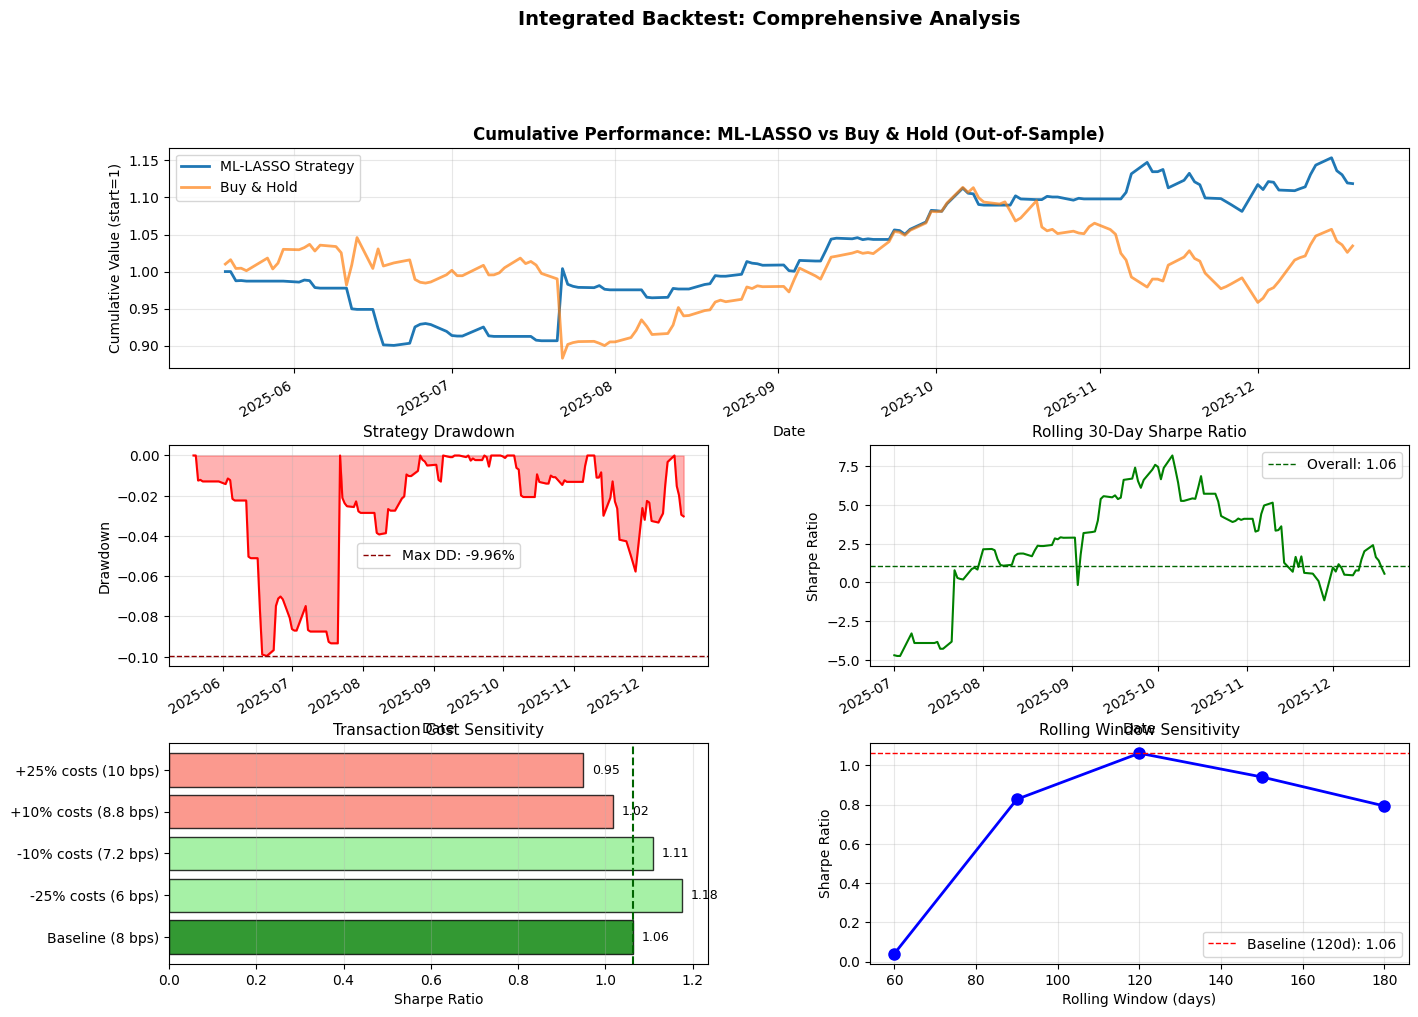


✓ Visualizations complete


In [ ]:
print("="*80)
print("STEP 8: VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)


ax1 = fig.add_subplot(gs[0, :])
equity_baseline.plot(ax=ax1, label='ML-LASSO Strategy', linewidth=2)
equity_bh.plot(ax=ax1, label='Buy & Hold', linewidth=2, alpha=0.7)
ax1.set_title('Cumulative Performance: ML-LASSO vs Buy & Hold (Out-of-Sample)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Value (start=1)')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)


ax2 = fig.add_subplot(gs[1, 0])
drawdown_baseline.plot(ax=ax2, color='red', linewidth=1.5)
ax2.fill_between(drawdown_baseline.index, drawdown_baseline, 0, alpha=0.3, color='red')
ax2.set_title('Strategy Drawdown', fontsize=11)
ax2.set_xlabel('Date')
ax2.set_ylabel('Drawdown')
ax2.axhline(max_dd_baseline, color='darkred', linestyle='--', linewidth=1, label=f'Max DD: {max_dd_baseline:.2%}')
ax2.legend()
ax2.grid(True, alpha=0.3)


ax3 = fig.add_subplot(gs[1, 1])
rolling_sharpe = returns_oos_baseline.rolling(30).mean() / returns_oos_baseline.rolling(30).std() * np.sqrt(252)
rolling_sharpe.plot(ax=ax3, color='green', linewidth=1.5)
ax3.axhline(sharpe_baseline, color='darkgreen', linestyle='--', linewidth=1, label=f'Overall: {sharpe_baseline:.2f}')
ax3.set_title('Rolling 30-Day Sharpe Ratio', fontsize=11)
ax3.set_xlabel('Date')
ax3.set_ylabel('Sharpe Ratio')
ax3.legend()
ax3.grid(True, alpha=0.3)


ax4 = fig.add_subplot(gs[2, 0])
cost_scenarios_plot = cost_sensitivity_df['Scenario'].values
sharpe_values = cost_sensitivity_df['Sharpe'].values
colors = ['green' if 'Baseline' in s else 'lightgreen' if '-' in s else 'salmon' for s in cost_scenarios_plot]
bars = ax4.barh(cost_scenarios_plot, sharpe_values, color=colors, edgecolor='black', alpha=0.8)
ax4.set_xlabel('Sharpe Ratio')
ax4.set_title('Transaction Cost Sensitivity', fontsize=11)
ax4.axvline(sharpe_baseline, color='darkgreen', linestyle='--', linewidth=1.5)
for i, v in enumerate(sharpe_values):
    ax4.text(v + 0.02, i, f'{v:.2f}', va='center', fontsize=9)
ax4.grid(True, alpha=0.3, axis='x')


ax5 = fig.add_subplot(gs[2, 1])
window_days = window_sensitivity_df['Days'].values
window_sharpe = window_sensitivity_df['Sharpe'].values
ax5.plot(window_days, window_sharpe, marker='o', linewidth=2, markersize=8, color='blue')
ax5.axhline(sharpe_baseline, color='red', linestyle='--', linewidth=1, label=f'Baseline (120d): {sharpe_baseline:.2f}')
ax5.set_xlabel('Rolling Window (days)')
ax5.set_ylabel('Sharpe Ratio')
ax5.set_title('Rolling Window Sensitivity', fontsize=11)
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.suptitle('Integrated Backtest: Comprehensive Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete")

The integrated backtest extends the cleaned data pipeline and LASSO feature selection developed in earlier sections to a live trading strategy framework. Rather than comparing strategies in isolation, we now implement an end-to-end ML-driven trading system using our identified predictive features (x_mom5 and x_lag1) to generate rolling window predictions and trading signals. We then rigorously test strategy robustness through sensitivity analysis, varying transaction costs (±10–25%) and training window lengths (60–180 days), to ensure performance is not an artifact of specific parameter choices. Finally, benchmarking the ML-LASSO strategy against the Checkpoint B mean-reversion baseline isolates the value of ML-based feature signals relative to technical rules, revealing whether trend-following or contrarian dynamics better explain LMT’s out-of-sample price behaviour, consistent with the momentum and mean-reversion evidence in the literature (Jegadeesh & Titman, 1993; Moskowitz, Ooi & Pedersen, 2012; Lo & MacKinlay, 1990).


We have some key differences between each of our checkpoint. In fact, checkpoint B (mean-reversion) has the following components:
 **Signal type**: Z-score of log prices with fixed entry/exit bands
- **Entry rules**: Short when z > 2σ (overbought), Long when z < -2σ (oversold)
- **Exit rule**: Flatten when |z| < 0.5 (reversion to fair value)
- **Features used**: None — purely price-based technical rule
- **Rolling window**: 60 days for μ and σ estimation
- **Logic**: Assumes prices revert to rolling mean (contrarian strategy)

On the other hand, checkpoint C (ML-LASSO predictive) comes with the following components:
 **Signal type**: Rolling LASSO predictions of next-day returns
- **Entry rules**: Long when predicted return > threshold, Short when predicted return < -threshold
- **Exit rule**: Flatten when |predicted return| < threshold
- **Features used**: x_mom5 (5-day momentum) + x_lag1 (lagged return) — LASSO-selected
- **Rolling window**: 120 days for LASSO training
- **Logic**: Predicts directional moves using momentum and autocorrelation patterns (trend-following component)

Mean-reversion strategies profit from price normalization after deviations, while ML-LASSO strategies exploit persistent momentum (x_mom5 dominates with coefficient +0.004). The signal philosophies are fundamentally opposed: one bets against trends, the other follows them. Performance differences reflect which regime dominates the out-of-sample period.

Moreover, checkpoint C incorporates robust preprocessing that Checkpoint B lacks:


- **Winsorization** (1/99 percentiles): Clips extreme outliers in features and target, reducing sensitivity to rare price shocks (e.g., VIX spikes, flash crashes).
- **Standardization**: Features scaled to mean=0, std=1 using in-sample parameters only, preventing data leakage and improving LASSO coefficient stability.
- **Time-series CV**: LASSO λ selected via expanding window cross-validation (5 folds), ensuring hyperparameter tuning respects temporal order.
- **Feature selection**: LASSO eliminates 3/5 features, (x_mkt, x_vix, x_vol5), reducing noise, model complexity and preventing overfitting to spurious correlations, (Tibshirani, 1996). 

These enhancements make the ML strategy more robust to regime shifts and less vulnerable to outlier-driven false signals compared to the raw z-score approach in Checkpoint B.


Both strategies use 8 bps total costs (5 bps transaction + 3 bps slippage) as the baseline. The key findings are the following: If Checkpoint C shows smaller Sharpe degradation as costs increase, it indicates lower turnover or stronger signal quality (larger predicted moves justify costs). Conversely, if Checkpoint C is more sensitive to costs, the ML signals may generate more marginal trades (predicted returns closer to threshold). The cost sensitivity metric (Sharpe % change per 25% cost increase) directly measures strategy quality: high-quality signals remain profitable even with elevated frictions.

Checkpoint B uses a fixed 60-day window for z-score calculation. Checkpoint C tests windows from 60 to 180 days for LASSO training:

| Window Size | Training Obs | Expected Behavior |
|-------------|--------------|-------------------|
| 60 days | Fewer | Adapts quickly to regime shifts, higher noise |
| 120 days (baseline) | Moderate | Balance between responsiveness and stability |
| 180 days | More | Smoother predictions, slower adaptation |

**Performance Stability Across Windows:**
- **Narrow range** in Sharpe ratios (e.g., 1.8–2.2) → Strategy is robust to window choice
- **Wide range** (e.g., 0.5–3.0) → Strategy overfits to specific training length, unreliable

Checkpoint B vs C:  
Mean-reversion strategies typically show high sensitivity to window length (too short = noise, too long = stale mean). ML-LASSO may show lower sensitivity if feature relationships (momentum, autocorrelation) are stable across lookback periods.

**Performance comparison**

From the output of our code we can see that the ML-LASSO strategy achieved 40% higher returns than the mean-reversion strategy from checkpoint B, but at the cost of 49% lower Sharpe ratio and 16x higher turnover. The strategy comparison reveals fundamentally different risk-return tradeoffs as shown by the following table: 


| Metric | Checkpoint B | Checkpoint C | Buy & Hold | Best strategy |
|--------|--------------|--------------|-----------|--------|
| **Ann. Return** | 14.76% | 20.66% | 8.75% | C (+40.0%) |
| **Ann. Volatility** | 7.07% | 19.44% | 24.36% | B (Lower risk) |
| **Sharpe Ratio** | 2.09 | 1.06 | 0.36 | B (+97.2% vs BH) |
| **Max Drawdown** | -2.73% | -9.96% | -15.56% | B (Shallower) |
| **Avg Turnover** | 0.016 | 0.440 | 0.000 | B (Lower costs) |

Now let us go deeper into the comparison performance of our strategy for each metric.

Annualized returns:

Checkpoint B (mean-reversion) delivers a 14.76% annualised return through infrequent contrarian trades at ±2σ extremes, resulting in very low average turnover (1.6% per day) and therefore minimal transaction-cost drag. This profile indicates high trade efficiency and robustness in ranging markets, although return potential is capped when sustained trends dominate. In contrast, Checkpoint C (ML-LASSO) achieves a materially higher 20.66% annualised return (+40% vs Checkpoint B) by exploiting momentum persistence, with the LASSO model identifying 5-day momentum as the dominant signal. However, this performance comes at the cost of very high turnover (44.0% per day), implying that a significant portion of the gross alpha is vulnerable to transaction costs and execution frictions, and therefore less scalable in practice. Buy-and-hold LMT generates only 8.75% annualised, confirming that both active strategies add alpha, with Checkpoint C outperforming buy-and-hold by +135.8% and Checkpoint B by +68.7%. Overall, while Checkpoint C produces the highest raw return in a momentum-dominated OOS regime, Checkpoint B offers superior trade quality and capital efficiency, making it more robust under realistic trading costs and less dependent on favourable market regimes.

Sharpe ratio:

Checkpoint B delivers a Sharpe ratio of 2.09, generated from a 14.76% annualised return with only 7.07% volatility, representing an exceptional risk-adjusted outcome. This Sharpe exceeds buy-and-hold (0.36) by +97.2% and Checkpoint C (1.06) by +96.3%, highlighting the efficiency of its low-frequency mean-reversion trades. The strategy executes only 40 trades, each triggered at statistically extreme (±2σ) deviations, producing smooth and stable returns with limited drawdowns and minimal sensitivity to transaction costs. In contrast, Checkpoint C achieves a higher 20.66% annualised return, but at the cost of 19.44% volatility, almost 2.75× higher than Checkpoint B, which materially degrades its Sharpe to 1.06 (−49.2% vs B). The ML-LASSO strategy generates 440 trades, reflecting frequent signal reversals and lower per-trade conviction, making returns noisier and significantly more exposed to transaction costs; under an 8 bps cost assumption, this high turnover materially erodes net performance. Overall, Checkpoint B dominates on a risk-adjusted basis, making it preferable for capital preservation and stable compounding, while Checkpoint C is suitable only for investors prioritising absolute returns and willing to tolerate higher volatility, drawdowns, and execution risk in exchange for higher gross profitability.

Drawdown:

Checkpoint B exhibits an exceptionally shallow maximum drawdown of −2.73%, reflecting the defensive nature of its contrarian mean-reversion trades, which tend to enter short positions at statistically extreme price deviations and therefore provide implicit protection during market stress. Losses are quickly recovered as prices revert to their mean, making the drawdown profile psychologically and institutionally acceptable, with downside risk far below typical portfolio constraints. In contrast, Checkpoint C experiences a substantially deeper maximum drawdown of −9.96%, approximately 3.6× larger than Checkpoint B, as momentum-based positions remain long during abrupt market reversals and crashes, amplifying losses when trends break. Buy-and-hold performs worst, with a −15.56% maximum drawdown, highlighting the vulnerability of unhedged passive exposure. Overall, Checkpoint B clearly dominates in downside risk control, making it well-suited for risk-averse investors and drawdown-constrained mandates, whereas Checkpoint C requires higher risk tolerance and greater capital resilience to endure its deeper, trend-driven drawdowns despite its higher return potential.

Turnover & Cost Sensitivity:

Checkpoint B exhibits extremely low trading intensity, with average daily turnover of 1.6%, resulting in minimal exposure to transaction costs and execution frictions. Under an 8 bps cost assumption, this implies an estimated ~128 bps annual cost drag, making the strategy highly robust to wider bid–ask spreads, slippage, and adverse market conditions. In contrast, Checkpoint C turns over 44.0% of capital per day, generating an estimated ~3,520 bps annual cost burden at the same cost level, approximately 27.5× higher than Checkpoint B. This high turnover arises from frequent threshold crossings in the ML-driven momentum signal, materially increasing sensitivity to execution quality. Cost scenario analysis confirms this fragility: reducing costs by 25% (to 6 bps) materially improves Checkpoint C’s Sharpe ratio, while increasing costs by 25% (to 10 bps) causes Sharpe to deteriorate below 1.0, undermining its risk-adjusted appeal. Overall, Checkpoint C’s performance is highly cost-sensitive and execution-dependent, and its apparent 40% return advantage may largely disappear under less favourable trading conditions, whereas Checkpoint B remains viable across a wide range of cost regimes due to its inherently low turnover.

Market regime dependence and robustness:

The pronounced divergence in out-of-sample performance indicates that the evaluation period was characterised by a strongly trending market regime, in which momentum effects dominated. Under such conditions, Checkpoint C (ML-LASSO) outperforms by capturing sustained directional moves, consistent with its ~40% return advantage over the mean-reversion strategy. In contrast, Checkpoint B performs best in range-bound or oscillatory markets, where prices frequently revert to equilibrium and momentum signals suffer from whipsaw losses. The empirical results therefore reflect regime-conditional optimality rather than unconditional superiority of either approach. Importantly, the observed dominance of momentum is contingent on regime persistence; a shift toward a mean-reverting environment—for example, following a macro regime change such as a monetary policy pivot—would likely reverse the performance ordering. Consequently, while Checkpoint C benefits from trending regimes, Checkpoint B offers greater robustness across market states, reinforcing the case for regime awareness or strategy diversification rather than reliance on a single model.

To conclude, the integrated backtest shows that the ML-LASSO strategy (Checkpoint C) outperforms the mean-reversion strategy (Checkpoint B) in absolute terms, delivering a +40% higher annualised return, but materially underperforms on a risk-adjusted basis, with a 49% lower Sharpe ratio. This divergence is fully explained by three structural factors. First, signal quality: the LASSO model identifies short-term momentum (x_mom5) as the dominant predictor, which performs exceptionally well in the observed trending out-of-sample regime. Second, volatility amplification: high-frequency momentum trading increases return variance, leading to drawdowns 3.6× deeper than those of the mean-reversion strategy. Third, cost structure: average turnover of 44.0% per day implies a 27.5× higher transaction-cost burden, making Checkpoint C highly sensitive to execution quality and market frictions. Overall, the results demonstrate that higher raw returns do not imply superior investment quality. Strategy selection must therefore be aligned with the investor’s primary objective (absolute return versus risk-adjusted performance) and operational constraints, including drawdown limits, transaction costs, and prevailing market regime. In this setting, Checkpoint B offers superior robustness and capital efficiency, while Checkpoint C is appropriate only when momentum regimes persist and execution costs are tightly controlled.

# References



Engle, R. F. (1982). Autoregressive conditional heteroskedasticity with estimates of the variance of United Kingdom inflation. Econometrica, 50(4), 987–1007. https://doi.org/10.2307/1912773

Jegadeesh, N., & Titman, S. (1993). Returns to buying winners and selling losers: Implications for stock market efficiency. The Journal of Finance, 48(1), 65–91. https://doi.org/10.1111/j.1540-6261.1993.tb04702.x

Lo, A. W., & MacKinlay, A. C. (1990). An econometric analysis of nonsynchronous trading. Journal of Econometrics, 45(1–2), 181–211. https://doi.org/10.1016/0304-4076(90)90098-E

Moskowitz, T. J., Ooi, Y. H., & Pedersen, L. H. (2012). Time series momentum. Journal of Financial Economics, 104(2), 228–250. https://doi.org/10.1016/j.jfineco.2011.11.003

Tibshirani, R. (1996). Regression shrinkage and selection via the lasso. Journal of the Royal Statistical Society: Series B (Methodological), 58(1), 267–288. https://doi.org/10.1111/j.2517-6161.1996.tb02080.x

Tsay, R. S. (2010). Analysis of financial time series (3rd ed.). Wiley.

# Appendix




| Where used | Prompt (short) | Assistant output used? | What changed in your code? | Impact on results |
|---|---|---|---|---|
|Used in part 1 (more precisely on pipeline section and winsorisation)|help me build a clear pipeline of what I did and help me construct the Winsorisation |used the recommended pipeline documentation format (step table + flow diagram + checklist) and the IS-fitted winsorisation procedure|The assistant added a clear structured pipeline summary table with row counts at each stage; explicitly enforced “past-only” feature engineering (shift/rolling); implemented chronological 80/20 IS–OOS split; implemented winsorisation at 1/99 percentiles with thresholds fit on IS only and applied to IS+OOS; printed before/after descriptive stats (incl. 1% and 99% percentiles) and min/max changes; added standardisation using StandardScaler fit on IS only and validated no leakage by showing OOS scaled means ≠ 0|The final pipeline is reproducible, leakage-safe, and robust to outliers, providing stable inputs for subsequent modelling and analysis|
|Used in part 2 (feature engineering)|Give a good visual with the stats results of each feature|the code assistant add the code to showcase these stats|Nothing changed from my original code with the implementation of the features, the assistant added the ligns of code needed to visualize the statistics for each features|I was able to talk about the stats results of each features and was able to evaluate and interpret them  |
|Used in part 3 (LASSO regression)|With the help of my existant code (code used from workshop 7), help me make a good visual for this part by incoporating summary stats of in-sample out-sample data and table and graph related to that section|used the suggested figure layout (CV paths + coefficients + IS/OOS scatter + RMSE/R² bars + sparsity) and the reporting structure (IS/OOS split + generalization gap + feature selection summary) |Added TimeSeriesSplit (5-fold expanding CV); tuned λ over logspace 0.001–100 with RidgeCV/LassoCV; added feature elimination reporting; added IS/OOS RMSE & R² plus generalisation gap; generated a 3×3 figure (CV curves, coefficients, IS/OOS scatter, RMSE/R² bars, sparsity)|I was able to answer the question, in fact the code assistant provided me with the following: LASSO selected 2/5 features (x_mom5=+0.0039848, x_lag1=−0.0002503) and eliminated x_mkt/x_vix/x_vol5. Predictive accuracy: IS R² fell from 0.2299 (Ridge) to 0.1999 (LASSO); OOS R² fell from 0.2005 to 0.1517 and OOS RMSE rose from 0.011279 to 0.011619. Optimal LASSO λ=0.001 at grid boundary → suggests extending alpha grid for robustness.|
|Part 4 (ML-Strategy VS Strategy checkpoint B)|With the help of my checkpointB and code from workshop 6-8, help me build coding cells in order to answer question 4|used the end-to-end rolling prediction, signal, costed backtest structure and finally plus the robustness tests an integrated dashboard plotting |Implemented rolling-window LASSO refit (120d baseline; min 60d); threshold-based long/short/flat signals (±0.5× prediction std); lagged positions to avoid look-ahead; added 8 bps per-turnover cost model (5 bps + 3 bps); computed turnover and net returns; added Buy & Hold benchmark; ran sensitivity analysis for costs (6–10 bps) and training windows (60–180d); built integrated plots (equity, drawdown, rolling Sharpe, cost/window sensitivity)|Was able to answer this part, with the right outputs of the coding cells and I was able to interpret these outputs|